# Collating Traning Results

The training results are parsed and summarized in this notebook

In [1]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    import re
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from pathlib import Path
    from typing import *
    from tqdm import tqdm
    import torch
    import umap
    import os

### Get the hyperparameters from the training logs.

In [2]:
# Path to train.log
# path = "/Users/dsanchez/Documents/MCSIllinois/dlh_project/project_code/DescEmb/outputs/2024-04-20/00-38-41/train.log"
path = Path("outputs") # path to ALL experiments relative to project path of GitHub repo dlh_project

In [4]:
def read_log(path: Union[str, Path]):
    with open(path, "r") as f:
        lines = f.readlines()
    return lines

In [5]:
# path = "project_code/DescEmb/outputs/2024-04-20/00-38-41/train.log"
#train_log = read_log(path)

In [6]:
def create_pattern(token: str):
    return re.compile(r"'{}': '?(\w+)'?".format(token))

In [7]:
def parse_log(train_log: List[str], tokens: List[str]):
    hyperparams = {}
    for line in train_log:
        for tok in tokens:
            pattern = create_pattern(tok)
            match = pattern.search(line)
            if match:
                #print(match.group(1))
                text = match.group(1)
                if text != 'True' or text != 'False': 
                    hyperparams[tok] = match.group(1)
                else:
                    hyperparams[tok] = bool(match.group(1))
    return hyperparams


In [8]:
def get_trainlog_paths(root: Union[str, Path]):
    root = Path(root)
    return list(root.glob("*/*/train.log"))

In [9]:
def get_last_auprc(train_log: List[str], patterns: Dict[str, re.Pattern]):
    for line in train_log[::-1]:
        hit = patterns['auprc'].search(line)
        if hit:
            return hit.group(1)

In [10]:
def get_last_metric(train_log: List[str], metric: str, patterns: Dict[str, re.Pattern]):
    for line in train_log[::-1]:
        hit = patterns[metric].search(line) # e.g. metric = 'auprc'
        if hit:
            return hit.group(1)

In [11]:
def create_pattern_numerical(token: str):
    return re.compile(r"{}: (\d+(\.\d+)?)".format(token))

In [12]:
metrics = ['epoch','loss','auroc', 'auprc']
# create a pattern dictionay with the metrics as keys
patterns = {metric: create_pattern_numerical(metric) for metric in metrics}

In [13]:
def parse_experiment(root: Union[str, Path], tokens: List[str], patterns: Dict[str, re.Pattern]=None):
    l_trainlogs = get_trainlog_paths(root)
    df = pd.DataFrame()
    for log in tqdm(l_trainlogs):
        train_log = read_log(log)
        hyperparams = parse_log(train_log, tokens)
        run = log.parent.name
        hyperparams['run'] = log.parent#/run
        if "done training" in train_log[-1]:
            hyperparams['done'] = True
        else:
            hyperparams['done'] = False
        if patterns:
            for metric in patterns.keys():
                hyperparams[metric] = get_last_metric(train_log, metric, patterns)
        df = pd.concat([df, pd.DataFrame(hyperparams, index=[0])])
    if patterns:
        for metric in patterns.keys():
            df[metric] = df[metric].astype(float)
        order = tokens + list(patterns.keys())
    else:
        order = tokens
    order = [col for col in order if col in df.columns]# Return dataframe columns which exist 
    return df[order]

In [14]:
tokens = ['run', 'done', 'src_data', 'task', 'value_mode', 'embed_model', 'model', 'init_bert_params', 'init_bert_params_with_freeze', 'transfer']

In [15]:
patterns

{'epoch': re.compile(r'epoch: (\d+(\.\d+)?)', re.UNICODE),
 'loss': re.compile(r'loss: (\d+(\.\d+)?)', re.UNICODE),
 'auroc': re.compile(r'auroc: (\d+(\.\d+)?)', re.UNICODE),
 'auprc': re.compile(r'auprc: (\d+(\.\d+)?)', re.UNICODE)}

In [16]:
#df_experiments = parse_experiment("/Users/dsanchez/Documents/MCSIllinois/dlh_project/project_code/DescEmb/outputs", tokens, patterns)
df_experiments = parse_experiment(path, tokens, patterns)

In [17]:
df_experiments[df_experiments['src_data'] == 'pooled']

Empty DataFrame
Columns: [run, done, src_data, task, value_mode, embed_model, model, init_bert_params, init_bert_params_with_freeze, transfer, epoch, loss, auroc, auprc]
Index: []

In [18]:
df_experiments.head(5)

run   done  src_data task value_mode embed_model  \
0  outputs/2024-04-13/07-13-12  False  mimiciii  mlm         NV        None   
0  outputs/2024-04-13/07-13-22  False      eicu  mlm         NV        None   
0  outputs/2024-04-13/07-17-36  False  mimiciii  mlm         NV        None   
0  outputs/2024-04-13/07-26-31  False  mimiciii  mlm         NV        None   
0  outputs/2024-04-13/07-44-35  False  mimiciii  mlm         NV        None   

         model init_bert_params init_bert_params_with_freeze transfer  epoch  \
0  descemb_rnn            False                        False    False    NaN   
0  descemb_rnn            False                        False    False    NaN   
0  descemb_rnn            False                        False    False    NaN   
0  descemb_rnn            False                        False    False    NaN   
0  descemb_rnn            False                        False    False    NaN   

   loss  auroc  auprc  
0   NaN    NaN    NaN  
0   NaN    NaN    NaN  
0   NaN    NaN    NaN  
0   NaN    NaN    NaN  
0   NaN    NaN    NaN

In [19]:
df_experiments.to_excel("outputs/experiments.xlsx", index=False)

### Parsing the train.log file for metrics

In [3]:
def extract_metrics(line: str, patterns: Dict[str, re.Pattern]):
    epoch = patterns['epoch'].search(line).group(1)
    loss = patterns['loss'].search(line).group(1)
    auroc = patterns['auroc'].search(line).group(1)
    auprc = patterns['auprc'].search(line).group(1)
    return int(epoch), float(loss), float(auroc), float(auprc)

In [4]:
def extract_model(line: str, patterns: Dict[str, re.Pattern]):
    print(patterns)
    embed_model = patterns['embed_model'].search(line).group(1)
    model = patterns['model'].search(line).group(1)
    dataset = patterns['src_data'].search(line).group(1)
    task = patterns['task'].search(line).group(1)
    return str(embed_model), str(model), str(dataset), str(task)

In [5]:
def parse_experiment_metrics(root: Union[str, Path], patterns: Dict[str, re.Pattern]):
    l_trainlogs = get_trainlog_paths(root)
    print(f"Found {len(l_trainlogs)} train logs.")
    #df_metrics = pd.DataFrame(columns=['run', 'fold', 'epoch', 'loss', 'auroc', 'auprc'])
    dict_metrics = {'run': [], 'fold': [], 'epoch': [], 'loss': [], 'auroc': [], 'auprc': []}
    for log in tqdm(l_trainlogs):
        train_log = read_log(log)
        run = log.parent
        for line in train_log:
            if "[INFO]" in line:
                if "[train]" in line:
                    epoch, loss, auroc, auprc = extract_metrics(line, patterns)
                    dict_metrics['run'].append(run)
                    dict_metrics['fold'].append("train")
                    dict_metrics['epoch'].append(epoch)
                    dict_metrics['loss'].append(loss)
                    dict_metrics['auroc'].append(auroc)
                    dict_metrics['auprc'].append(auprc)
                elif "[valid]" in line:
                    epoch, loss, auroc, auprc = extract_metrics(line, patterns)
                    dict_metrics['run'].append(run)
                    dict_metrics['fold'].append("valid")
                    dict_metrics['epoch'].append(epoch)
                    dict_metrics['loss'].append(loss)
                    dict_metrics['auroc'].append(auroc)
                    dict_metrics['auprc'].append(auprc)
                elif "[test]" in line:
                    epoch, loss, auroc, auprc = extract_metrics(line, patterns)
                    dict_metrics['run'].append(run)
                    dict_metrics['fold'].append("test")
                    dict_metrics['epoch'].append(epoch)
                    dict_metrics['loss'].append(loss)
                    dict_metrics['auroc'].append(auroc)
                    dict_metrics['auprc'].append(auprc)
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics

In [24]:
df_metrics = parse_experiment_metrics("outputs", patterns)

Found 563 train logs.


100%|██████████| 563/563 [00:00<00:00, 1925.82it/s]


In [25]:
df_metrics.run.unique()

array([PosixPath('outputs/2024-04-13/09-50-38'),
       PosixPath('outputs/2024-04-13/09-54-57'),
       PosixPath('outputs/2024-04-13/10-06-26'),
       PosixPath('outputs/2024-04-13/10-27-57'),
       PosixPath('outputs/2024-04-13/10-38-53'),
       PosixPath('outputs/2024-04-13/10-49-36'),
       PosixPath('outputs/2024-04-13/11-01-15'),
       PosixPath('outputs/2024-04-13/11-12-22'),
       PosixPath('outputs/2024-04-13/11-52-28'),
       PosixPath('outputs/2024-04-13/12-07-30'),
       PosixPath('outputs/2024-04-13/12-26-57'),
       PosixPath('outputs/2024-04-13/13-02-15'),
       PosixPath('outputs/2024-04-13/13-15-05'),
       PosixPath('outputs/2024-04-13/13-40-36'),
       PosixPath('outputs/2024-04-13/13-48-11'),
       PosixPath('outputs/2024-04-13/14-02-26'),
       PosixPath('outputs/2024-04-13/14-21-48'),
       PosixPath('outputs/2024-04-13/14-32-44'),
       PosixPath('outputs/2024-04-13/15-09-18'),
       PosixPath('outputs/2024-04-13/16-47-55'),
       PosixPath('ou

In [26]:
len(df_metrics)

22560

In [27]:
df_metrics

run   fold  epoch   loss  auroc  auprc
0      outputs/2024-04-13/09-50-38  train      1  0.654  0.509  0.045
1      outputs/2024-04-13/09-54-57  train      1  0.654  0.509  0.045
2      outputs/2024-04-13/09-54-57  valid      1  0.647  0.502  0.045
3      outputs/2024-04-13/09-54-57   test      1  1.462  0.505  0.043
4      outputs/2024-04-13/09-54-57  train      2  0.645  0.509  0.045
...                            ...    ...    ...    ...    ...    ...
22555  outputs/2024-04-27/15-38-09  valid    130  0.363  0.774  0.434
22556  outputs/2024-04-27/15-38-09   test    130  0.651  0.780  0.447
22557  outputs/2024-04-27/15-38-09  train    131  0.336  0.824  0.535
22558  outputs/2024-04-27/15-38-09  valid    131  0.364  0.773  0.435
22559  outputs/2024-04-27/15-38-09   test    131  0.651  0.779  0.446

[22560 rows x 6 columns]

In [28]:
df_metrics.to_excel("outputs/metrics.xlsx", index=False)

In [90]:
def plot_metrics(df_metrics: pd.DataFrame, run: Union[str|List[str]], metrics: List[str] = ['loss', 'auroc', 'auprc'], folds: str = ['train', 'valid', 'test']):
    ncols = len(metrics)
    if isinstance(run, str):
        run = [run]
    nrows = len(run)
    height = 5*nrows
    width = 3*5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, height))
    axes = axes.ravel() if nrows > 1 else axes
    for j, r in enumerate(run):
        for i, metric in enumerate(metrics):
            for fold in folds:
                ax = axes[j*len(metrics) + i] if ncols > 1 else axes
                df_metrics.loc[(df_metrics['fold']==fold) & (df_metrics['run']==r)].plot(x='epoch', y=metric, ax=ax, label=fold)
                ax.set_title(metric)
    fig.suptitle(run)
    plt.tight_layout()
    plt.show()

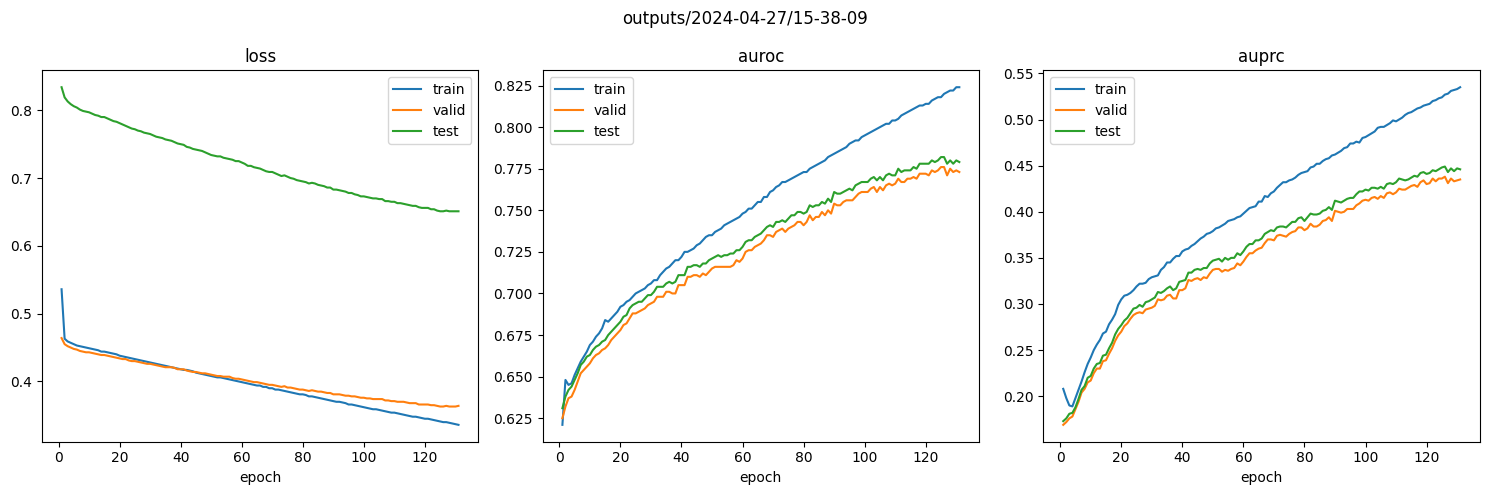

In [88]:
#plot_metrics(df_metrics, 'outputs/2024-04-20/21-59-10')
plot_metrics(df_metrics, 'outputs/2024-04-27/15-38-09',)

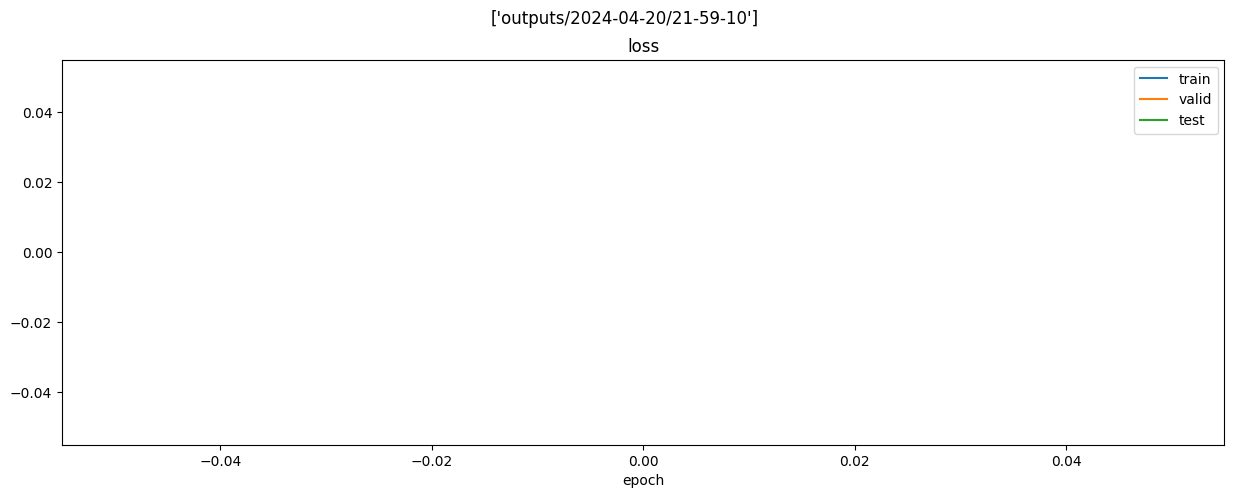

In [78]:
# Pretraining DescEmb-BERT
plot_metrics(df_metrics, 'outputs/2024-04-20/21-59-10', metrics=["loss"])

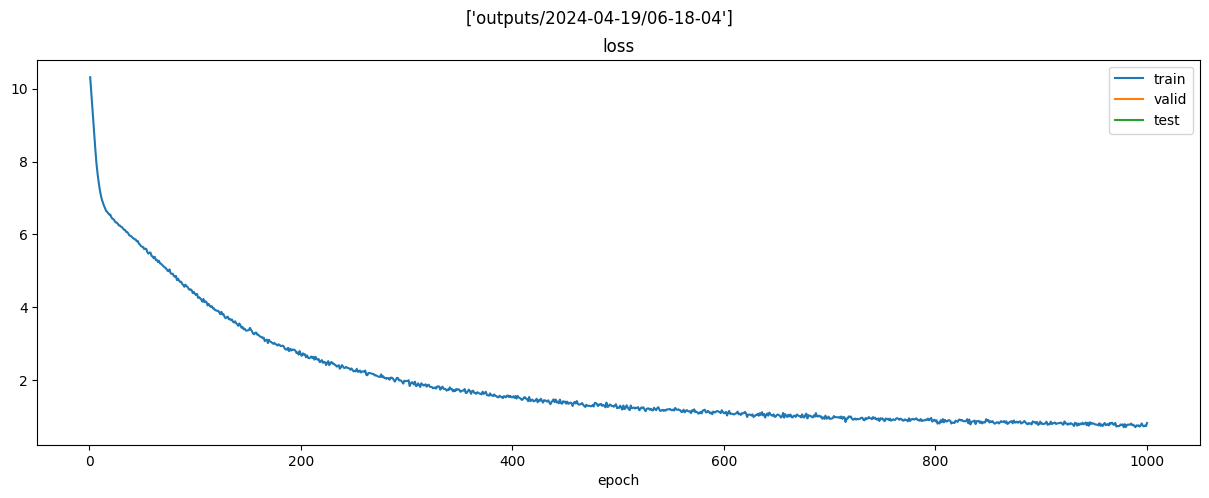

In [79]:
# Pretraining DescEmb-BERT
plot_metrics(df_metrics, 'outputs/2024-04-19/06-18-04', metrics=["loss"])

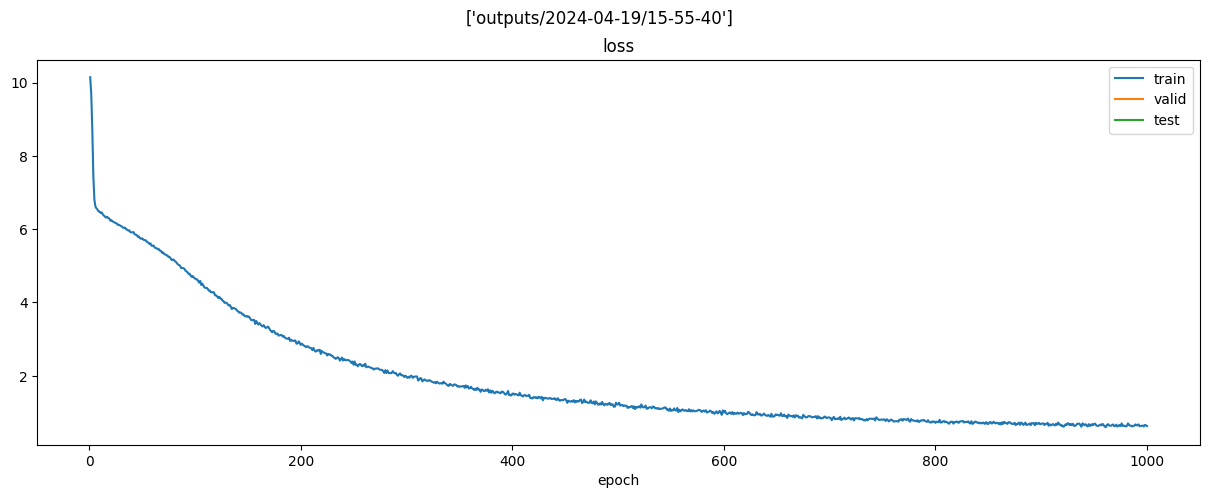

In [80]:
# Pretraining DescEmb-BERT
plot_metrics(df_metrics, 'outputs/2024-04-19/15-55-40', metrics=["loss"])

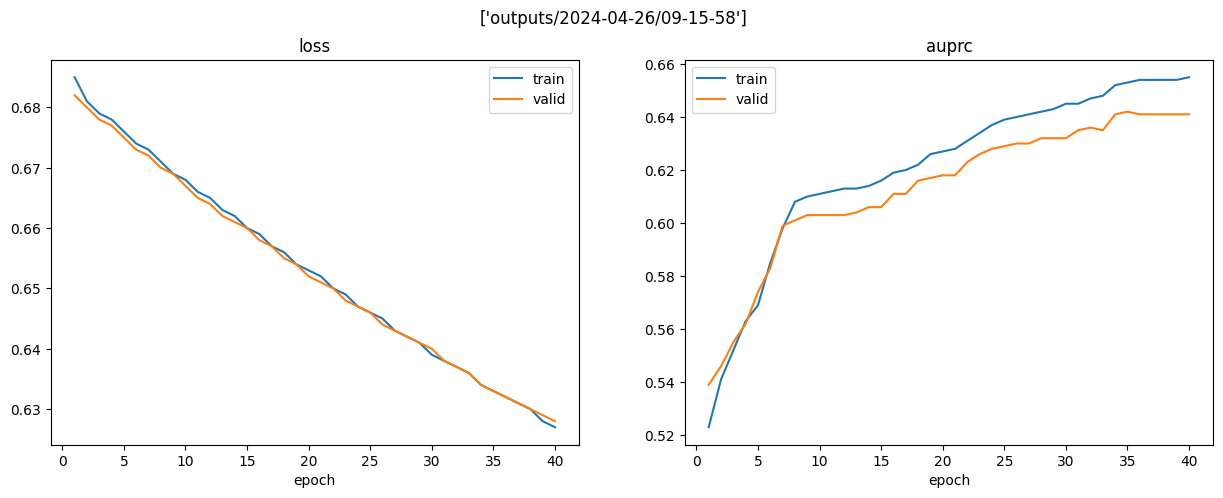

In [81]:
# Training new DescEmb-BERT CLS-FT (mimiciii, task diagnosis)
plot_metrics(df_metrics, 'outputs/2024-04-26/09-15-58', metrics=["loss", "auprc"], folds=["train", "valid"])

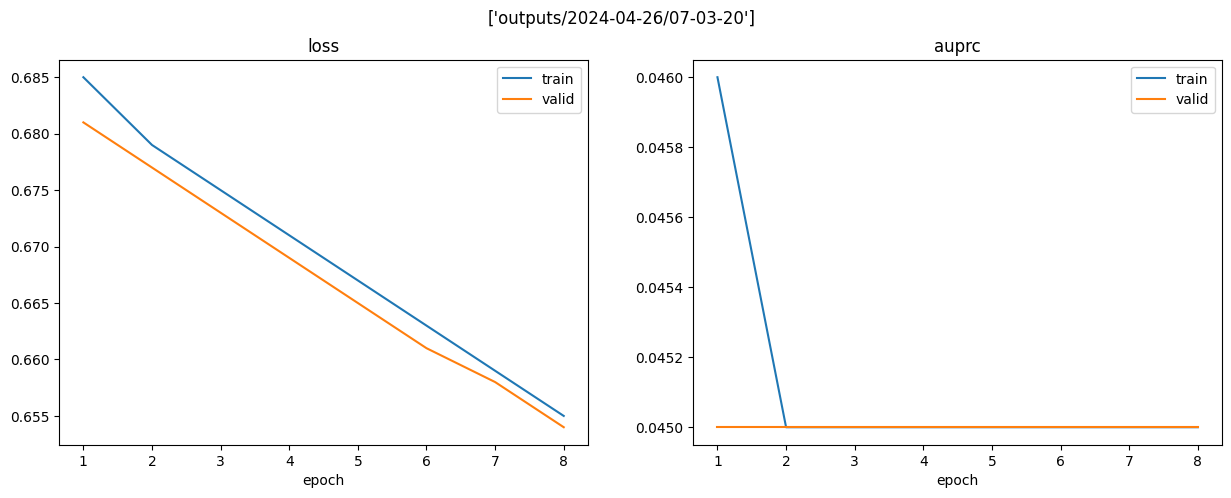

In [82]:
# Training new DescEmb-BERT CLS-FT (mimiciii, task readmission)
plot_metrics(df_metrics, "outputs/2024-04-26/07-03-20", metrics=["loss", "auprc"], folds=["train", "valid"])

In [83]:
df_metrics = pd.read_excel("outputs/metrics.xlsx")

Below is the training run with MLM pretraining and using trainable BERT weights for init. 

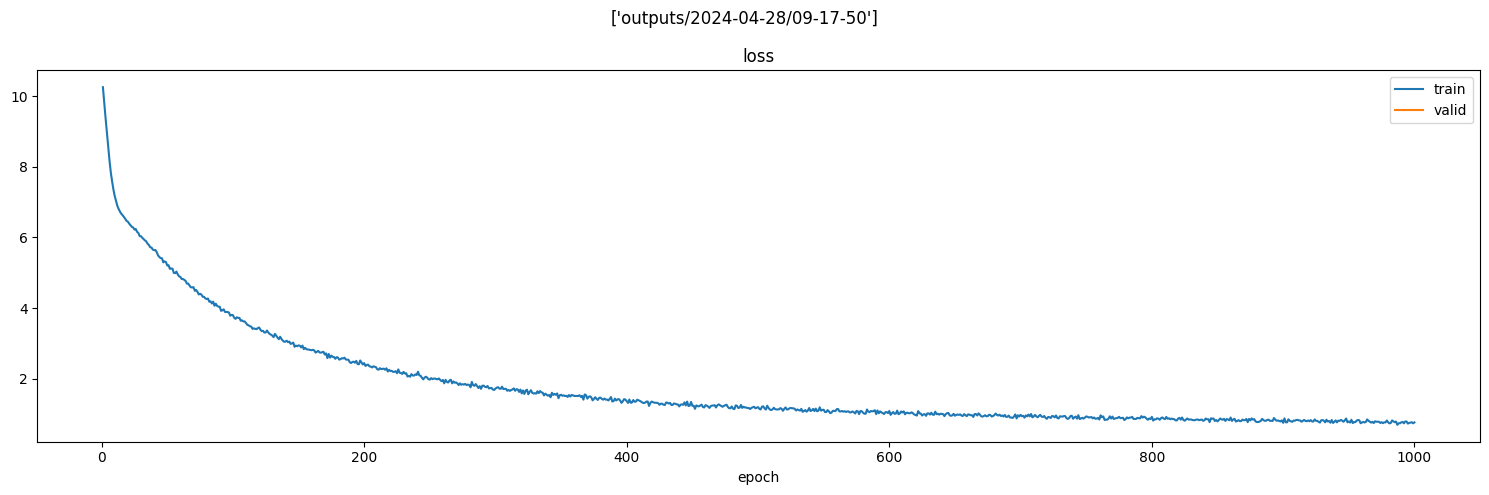

In [95]:
plot_metrics(df_metrics, 'outputs/2024-04-28/09-17-50', metrics=["loss"], folds=["train", "valid"])

These plots below are generated using MIMIC-III and training with CLS-FT and patience 400. Task is readmission.

In [92]:
runs = ['outputs/2024-04-28/10-31-31', 'outputs/2024-04-28/12-56-51', 'outputs/2024-04-28/19-05-24', 'outputs/2024-04-28/21-32-27']

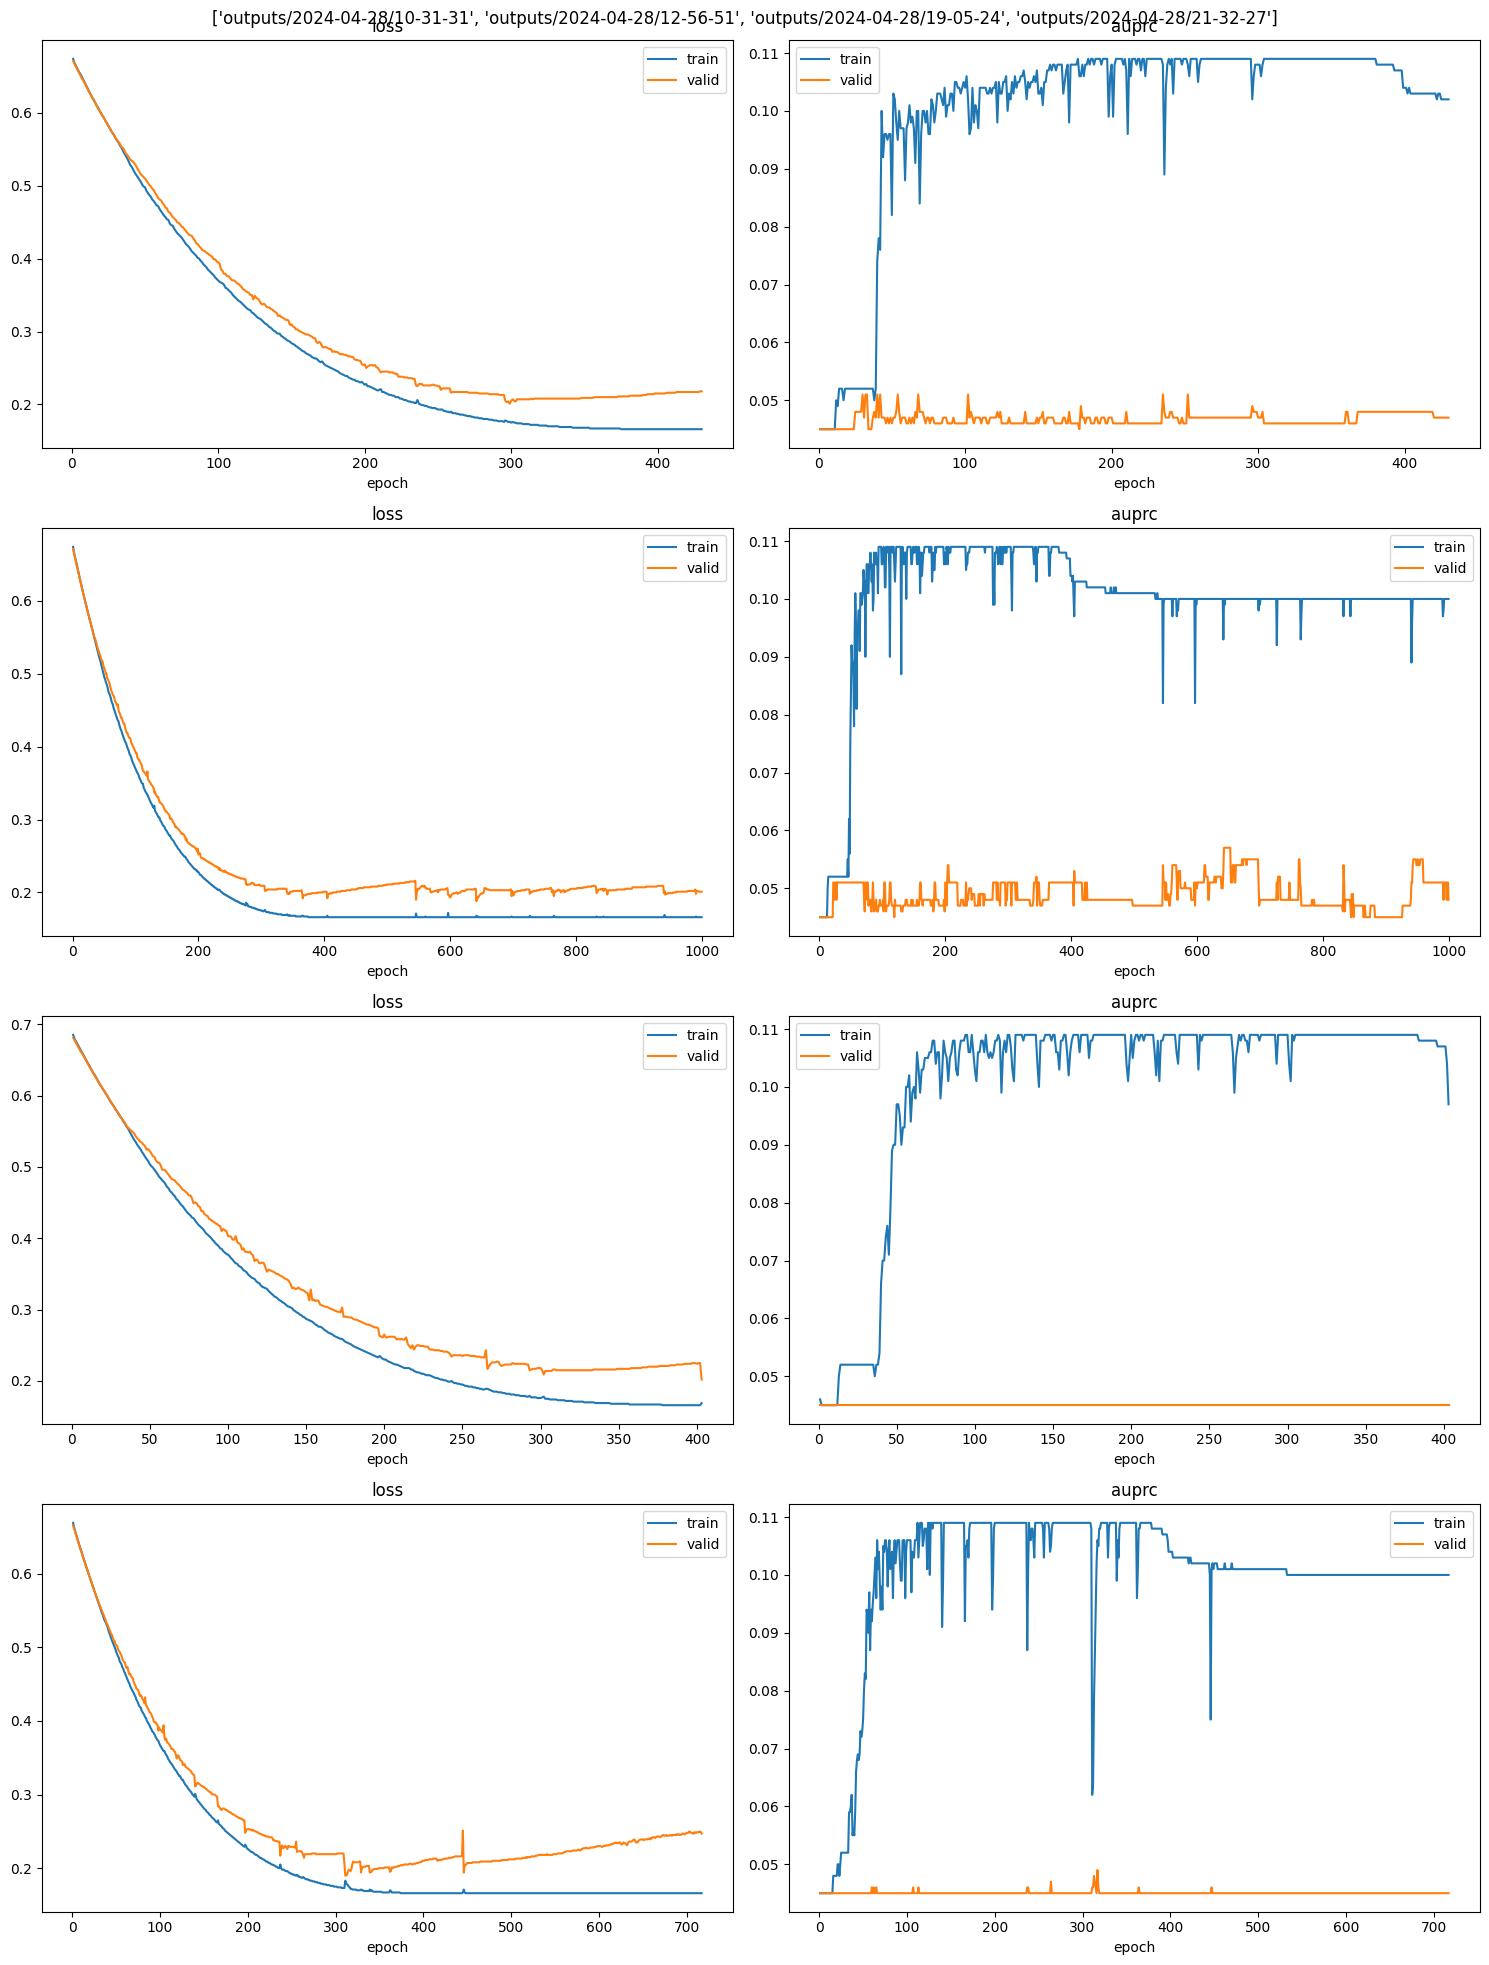

In [93]:
plot_metrics(df_metrics, runs, metrics=["loss", "auprc"], folds=["train", "valid"] )

Judging from the validation curves there is overfitting after about 300 epochs. The patience should be reduced to 200 or 100. It seems a little bit odd, why AUPRC is not increasing with the increase in the number of epochs.

Now the same , but for mortality task.

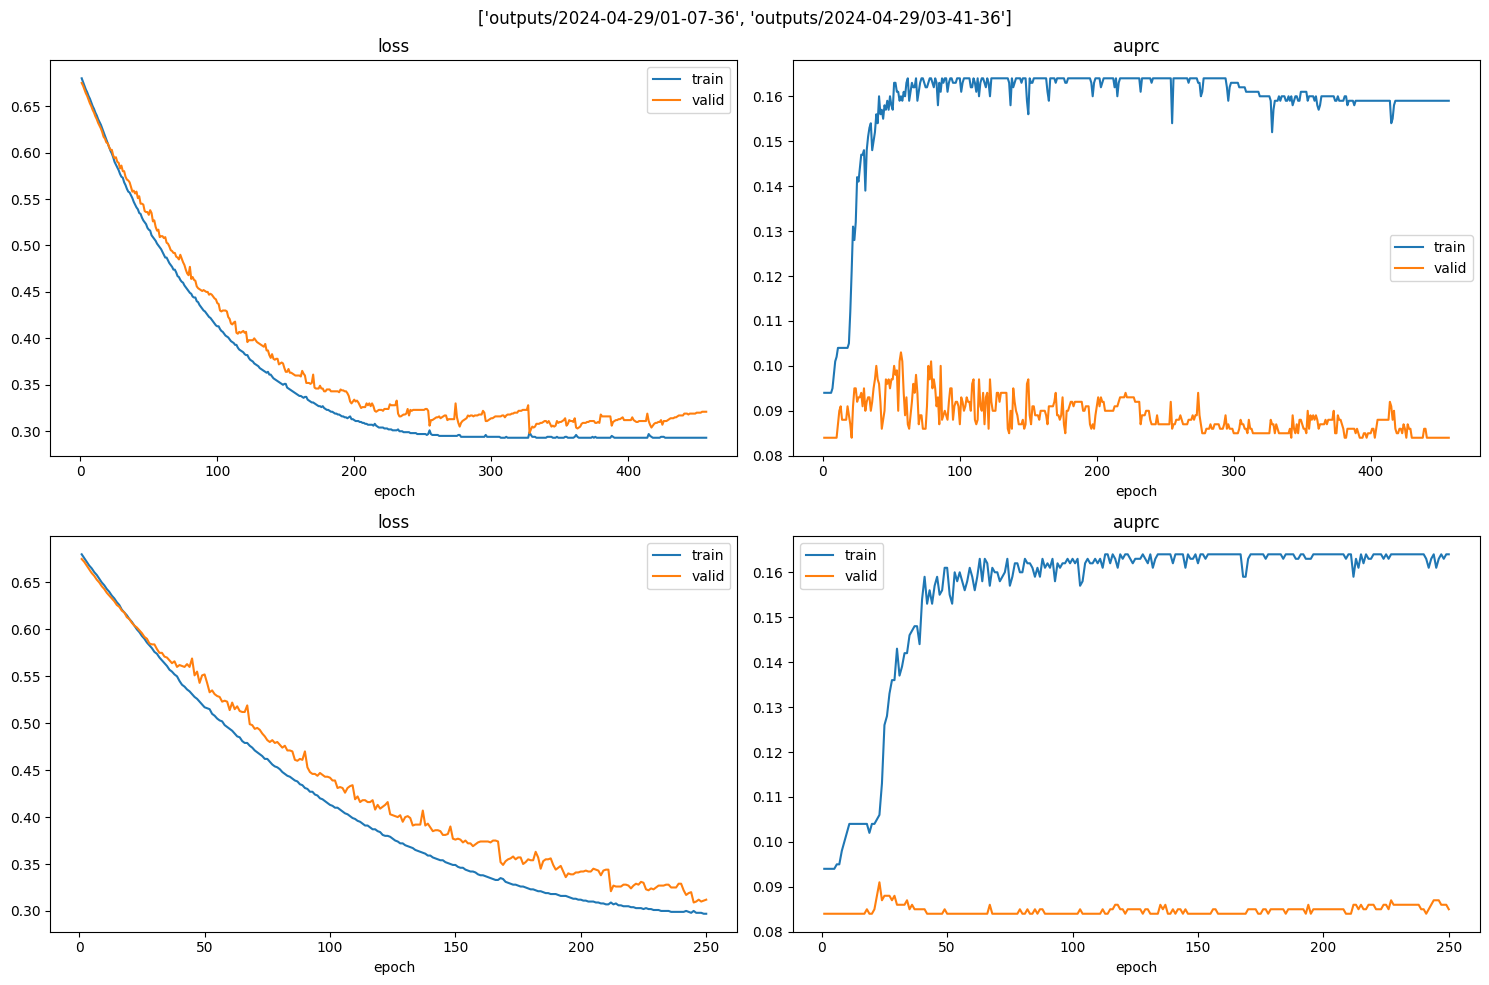

In [97]:
plot_metrics(df_metrics, ['outputs/2024-04-29/01-07-36', 'outputs/2024-04-29/03-41-36'], metrics=["loss", "auprc"], folds=["train", "valid"] )

### New Visualization and Analysis of Model

In [29]:
checkpoint = torch.load('/Users/dsanchez/Documents/MCSIllinois/dlh_project/outputs/2024-04-20/21-59-10/checkpoints/checkpoint_best.pt', map_location=torch.device('cpu'))
checkpoint.keys()
model_embeddings = checkpoint['model_state_dict']['embed_model.post_encode_proj.weight']

In [30]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(model_embeddings)
embedding.shape

(128, 2)

In [31]:
def draw_umap(data, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = reducer.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        #ax.scatter(u[:,0], range(len(u)), c=data)
        ax.scatter(u[:,0], range(len(u)))
    if n_components == 2:
        ax = fig.add_subplot(111)
        #ax.scatter(u[:,0], u[:,1], c=data)
        ax.scatter(u[:,0], u[:,1])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        #ax.scatter(u[:,0], u[:,1], u[:,2], c=data, s=100)
        ax.scatter(u[:,0], u[:,1], u[:,2], s=100)
    plt.title(title, fontsize=18)

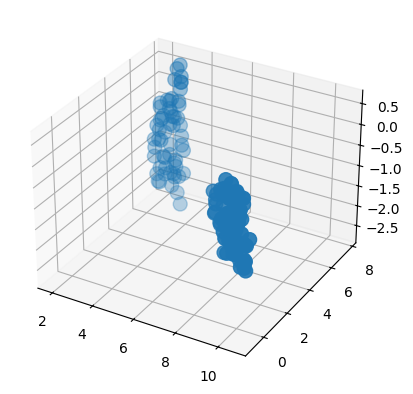

In [32]:
draw_umap(model_embeddings, n_components=3)

In [33]:
def plot_all_umaps():
    finished_runs = df_experiments[df_experiments['done'] == True]
    for i in range(finished_runs.shape[0]):
        experiment = finished_runs.iloc[i]
        run_path = experiment['run']
        checkpoint_path = os.path.join(run_path, 'checkpoints/checkpoint_best.pt')
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        model_embeddings = checkpoint['model_state_dict']['embed_model.post_encode_proj.weight']
        title = f"{experiment['src_data']}_{experiment['embed_model']}_{experiment['value_mode']}_{experiment['task']}"
        #title = f"{experiment['src_data']}"
        draw_umap(model_embeddings, n_components=2, title=title)
        draw_umap(model_embeddings, n_components=3, title=title)
        

In [34]:
checkpoint['model_state_dict']['pred_model.final_proj.weight']

tensor([[ 0.0625,  0.0144,  0.0152,  0.0450,  0.0383, -0.0635, -0.0394,  0.0392,
          0.0236,  0.0096, -0.0344, -0.0263, -0.0156,  0.0209, -0.0356,  0.0124,
          0.0398, -0.0626,  0.0075,  0.0044,  0.0326, -0.0380, -0.0383, -0.0737,
          0.0141,  0.0241, -0.0465, -0.0439, -0.0068,  0.0129, -0.0531,  0.0137,
          0.0588,  0.0514,  0.0572,  0.0139, -0.0243,  0.0164, -0.0526,  0.0262,
          0.0526,  0.0819,  0.0193, -0.0607,  0.0248,  0.0382, -0.0185, -0.0072,
          0.0265,  0.0479, -0.0441,  0.0666, -0.0298,  0.0082, -0.0509,  0.0013,
         -0.0415, -0.0425, -0.0028,  0.0115, -0.0300,  0.0585, -0.0334,  0.0498,
          0.0087, -0.0548,  0.0502, -0.0119,  0.0260, -0.0455,  0.0310,  0.0326,
          0.0094,  0.0437, -0.0181, -0.0533, -0.0451,  0.0484, -0.0563,  0.0203,
         -0.0509,  0.0608, -0.0590,  0.0541,  0.0107,  0.0419,  0.0581,  0.0085,
          0.0036,  0.0253, -0.0709, -0.0127, -0.0375,  0.0052, -0.0283, -0.0029,
          0.0723, -0.0522, -

In [35]:
# Is MPS even available? macOS 12.3+
print(torch.backends.mps.is_available())

# Was the current version of PyTorch built with MPS activated?
print(torch.backends.mps.is_built())

True
True


/var/folders/pl/j178b_y166916cz1sd0rxbrr0000gn/T/ipykernel_39471/61296453.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


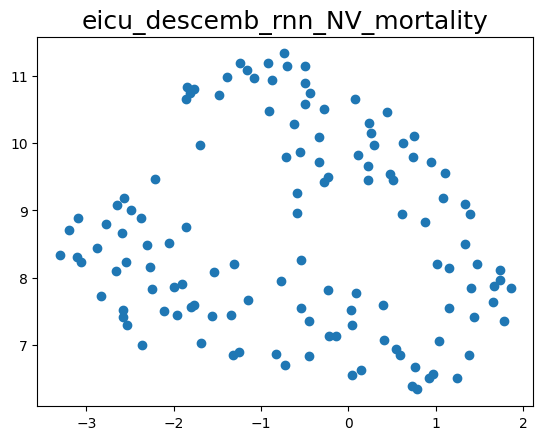

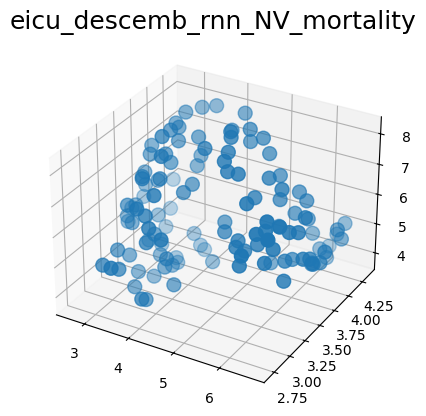

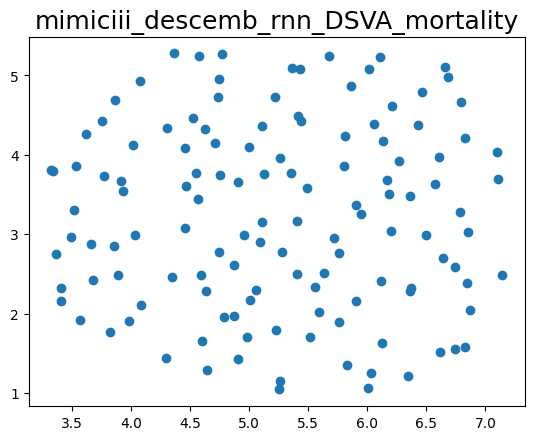

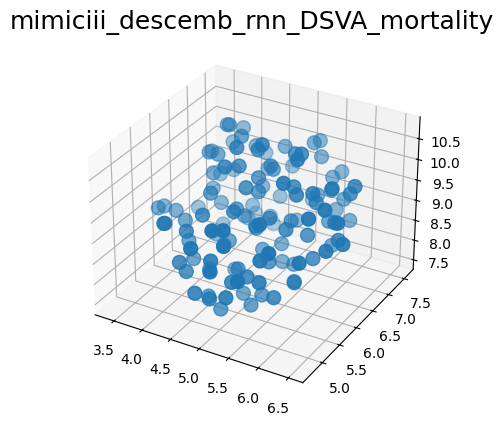

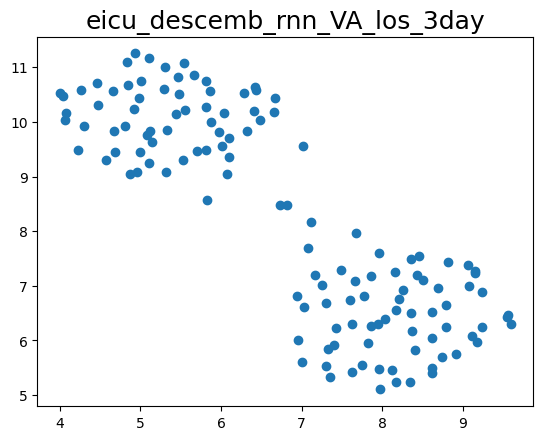

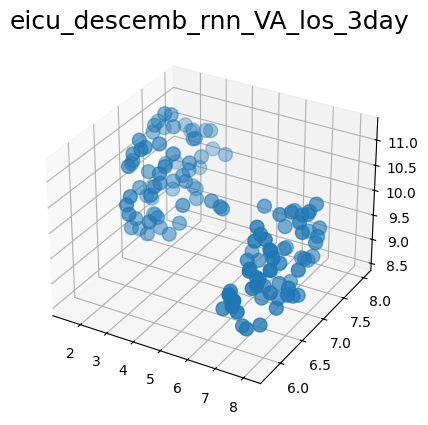

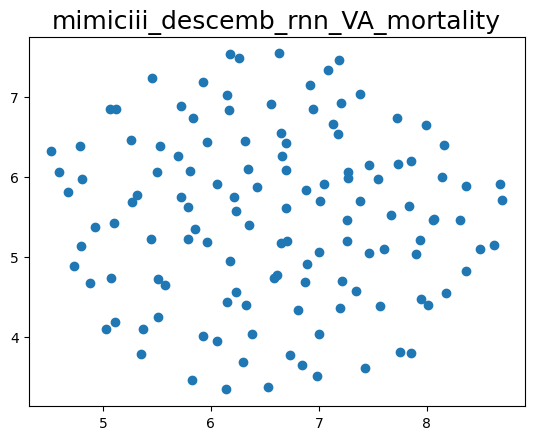

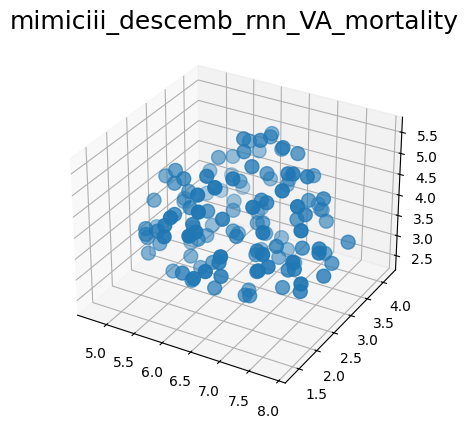

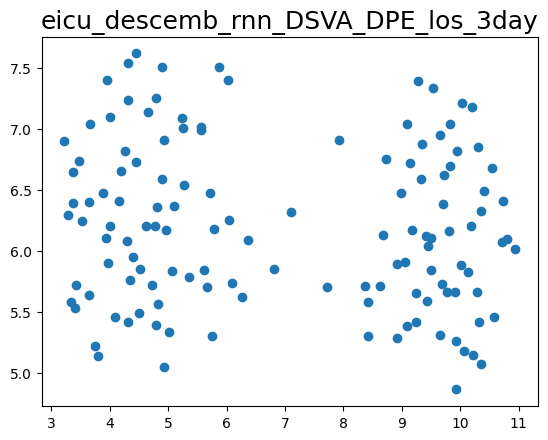

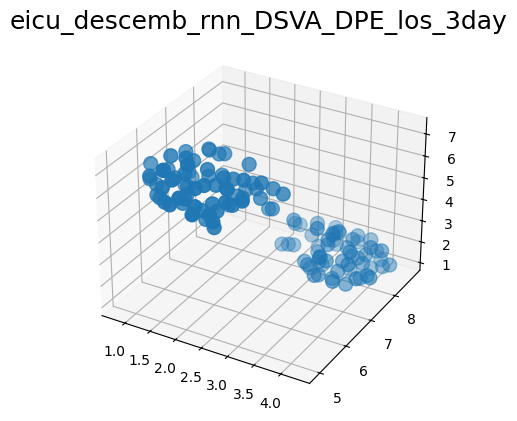

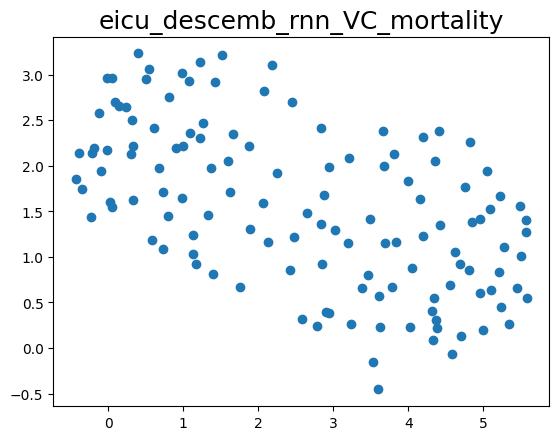

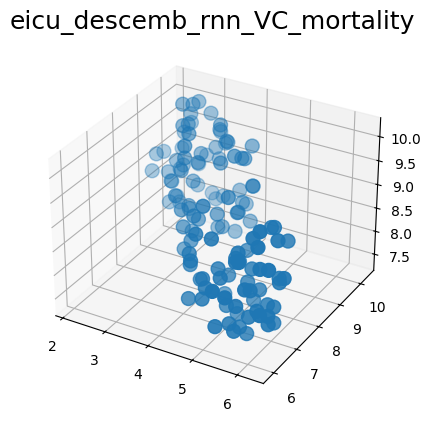

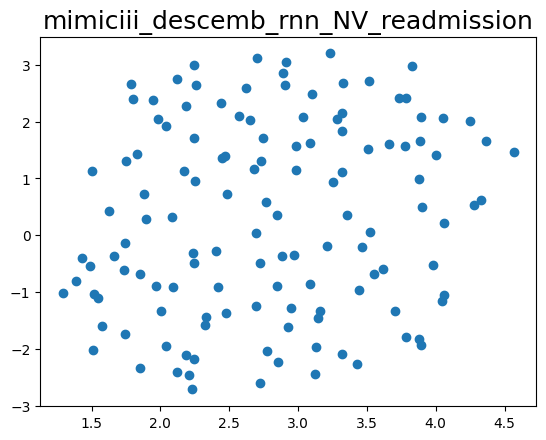

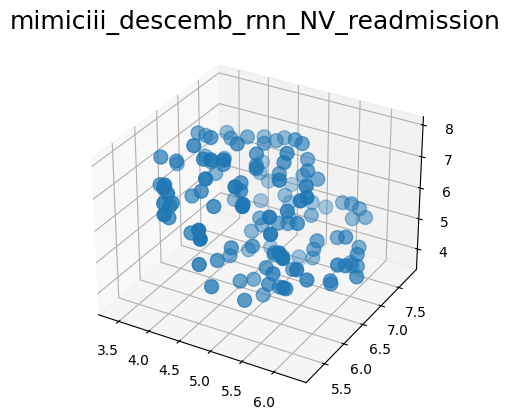

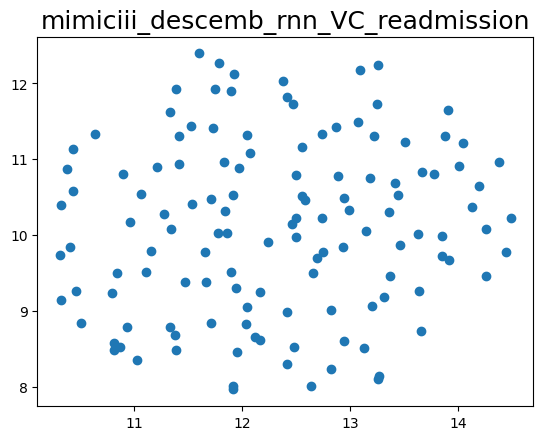

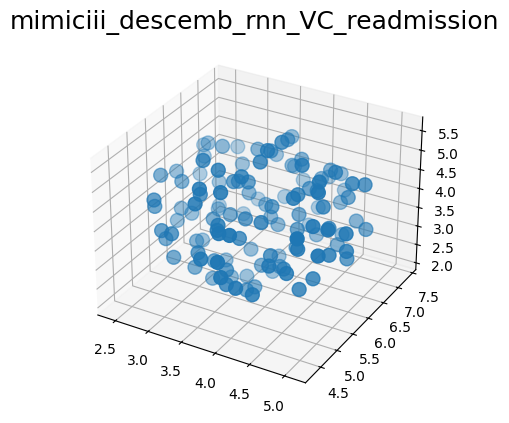

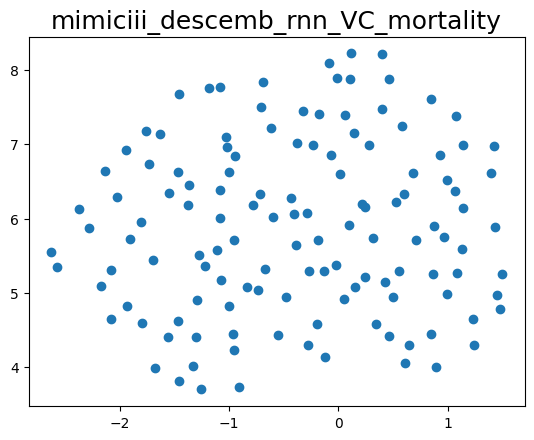

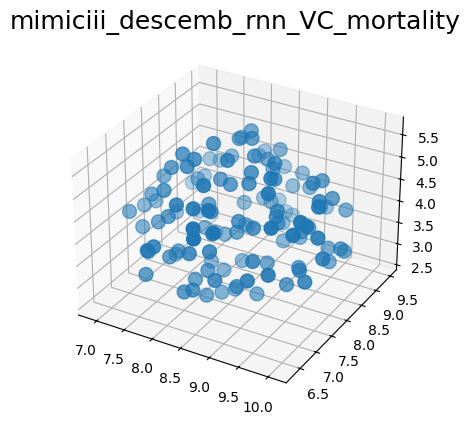

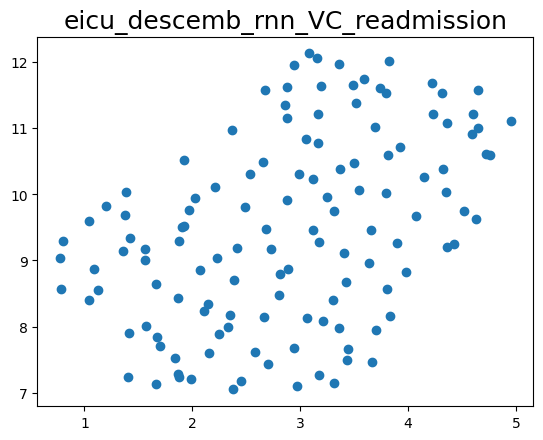

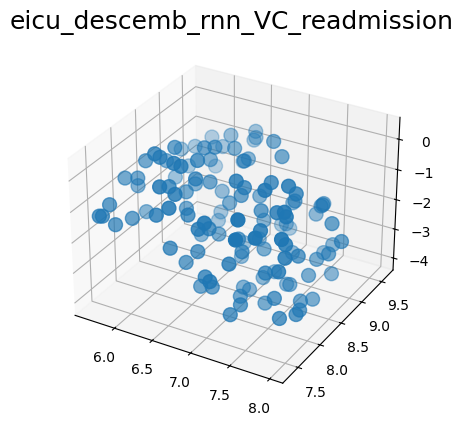

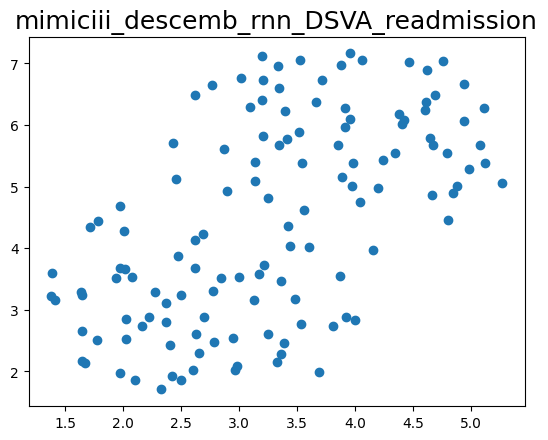

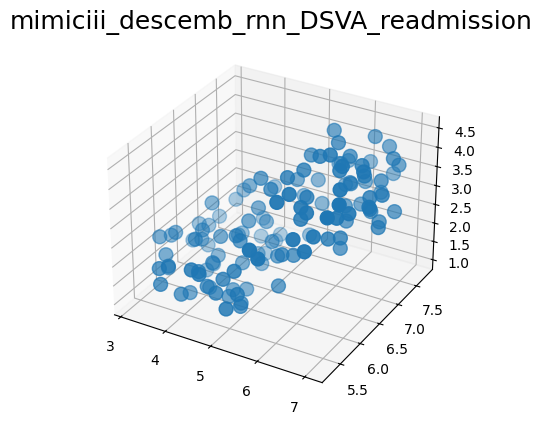

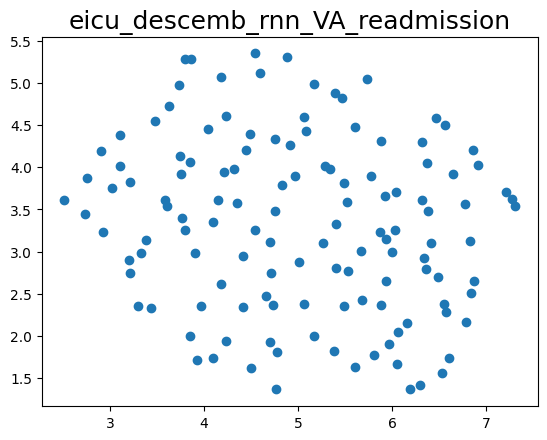

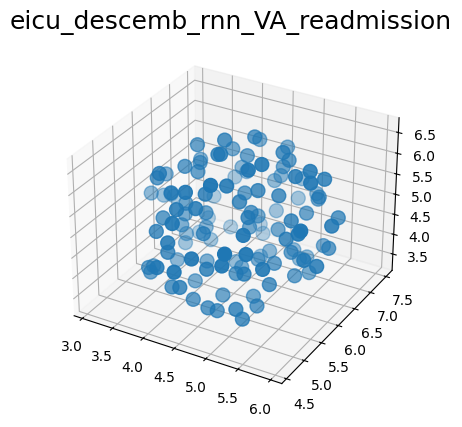

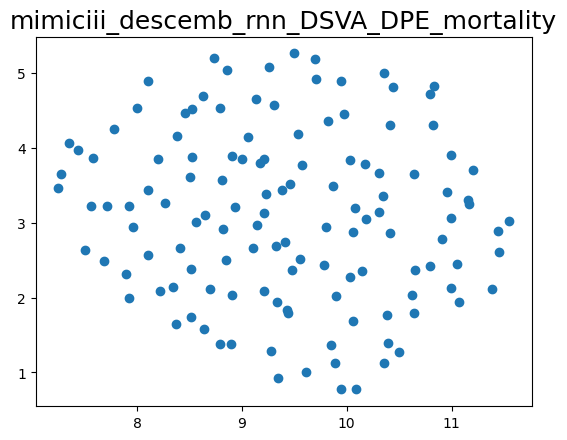

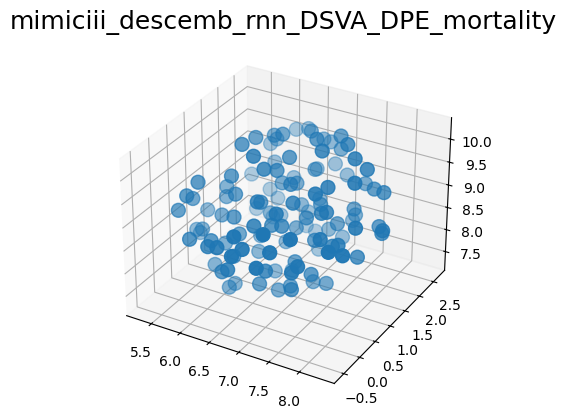

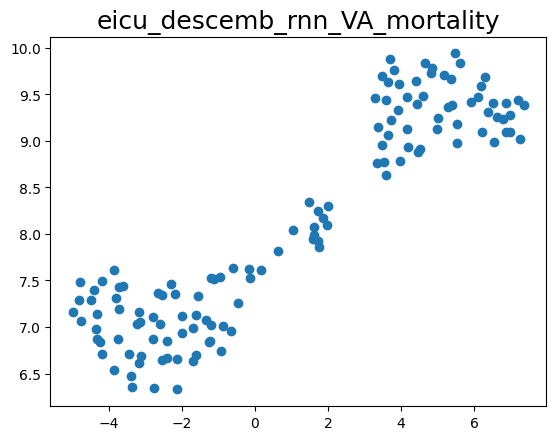

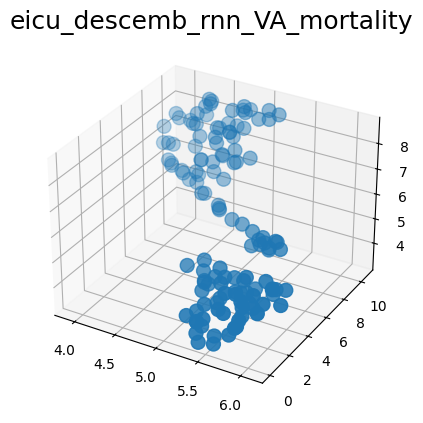

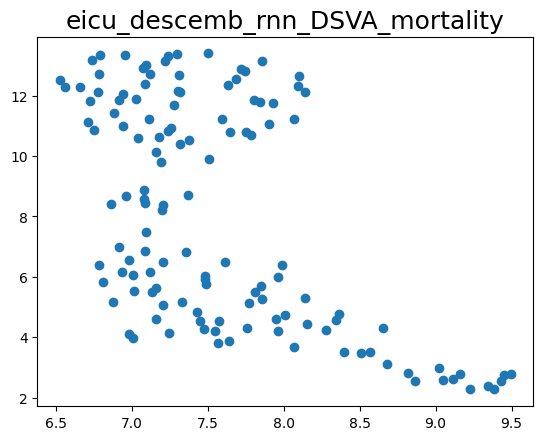

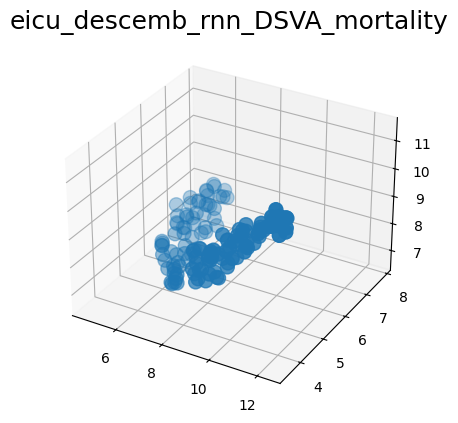

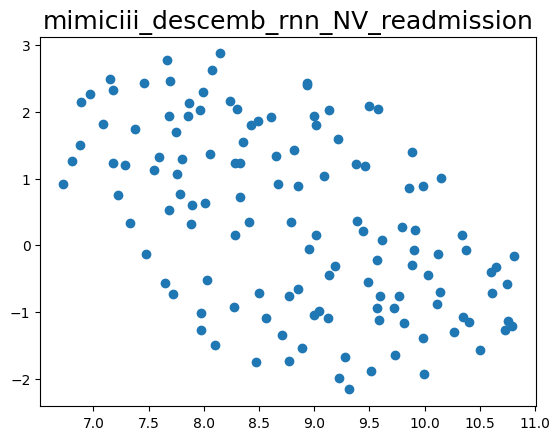

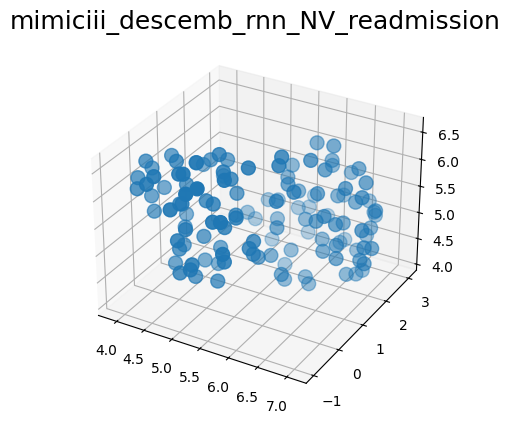

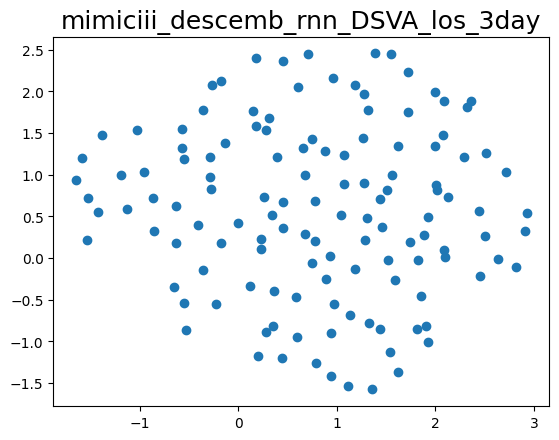

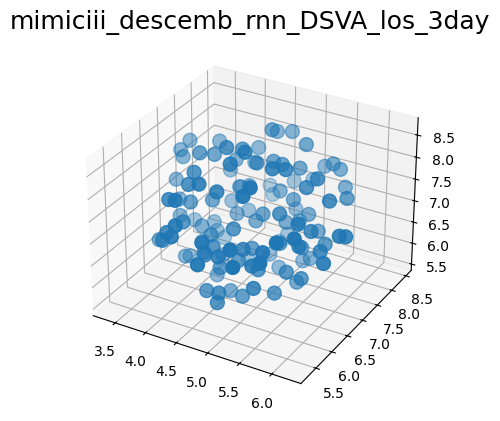

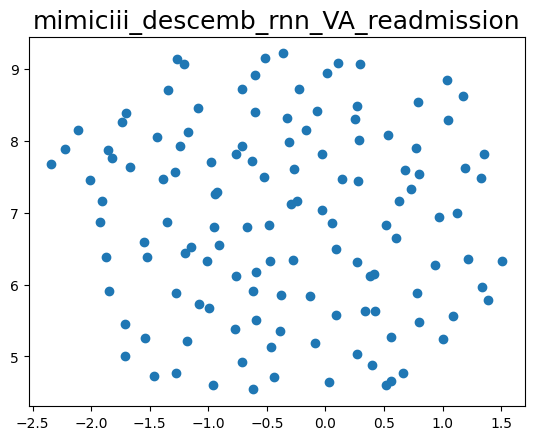

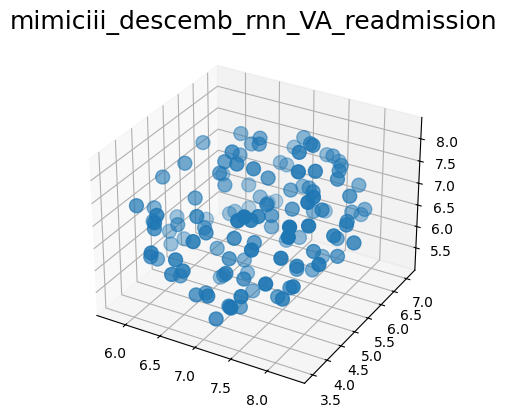

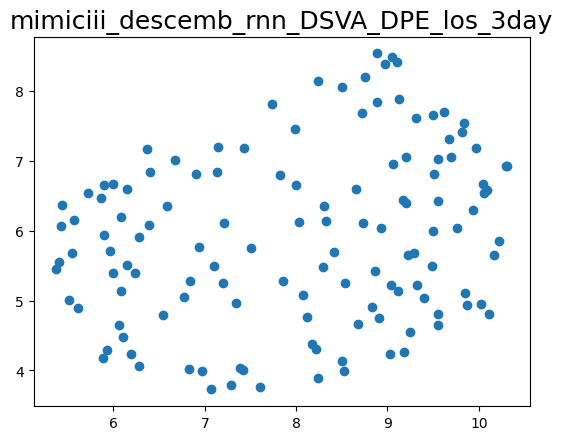

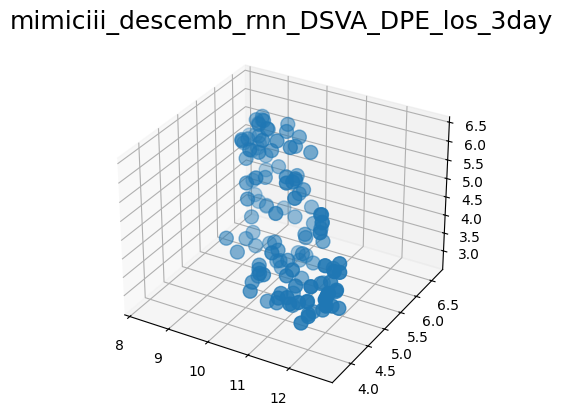

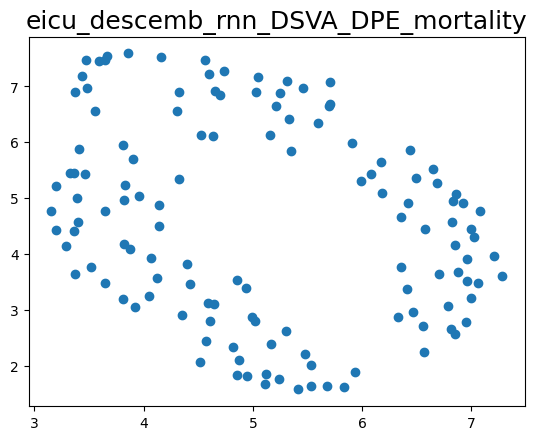

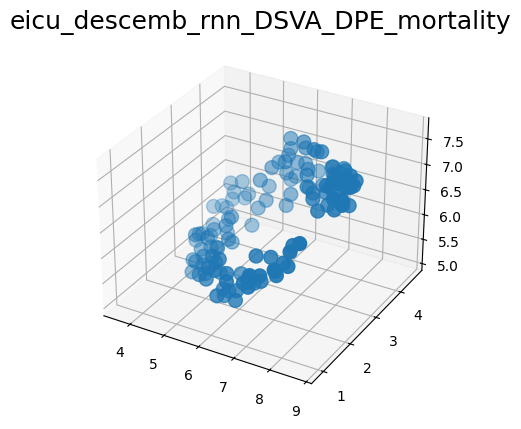

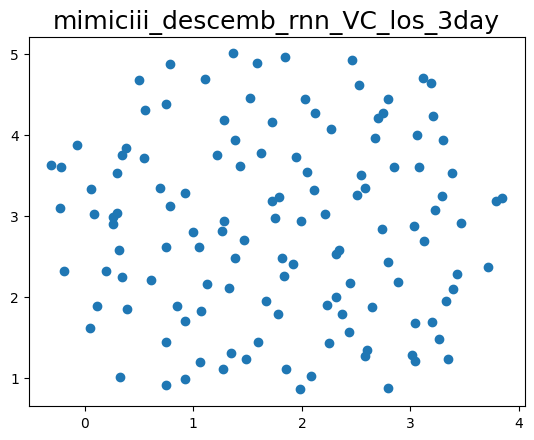

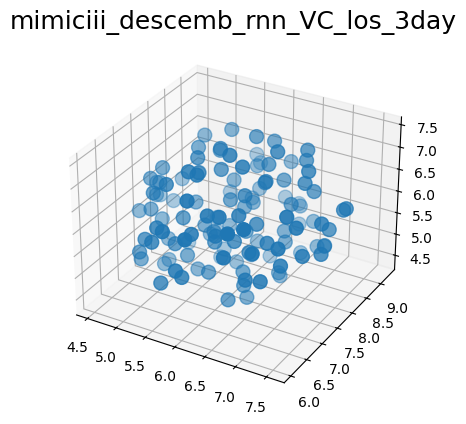

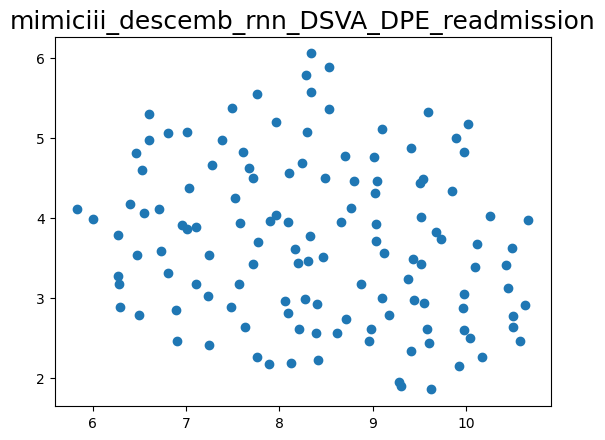

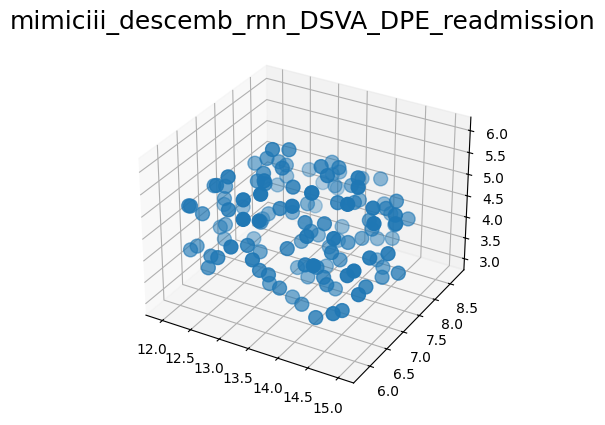

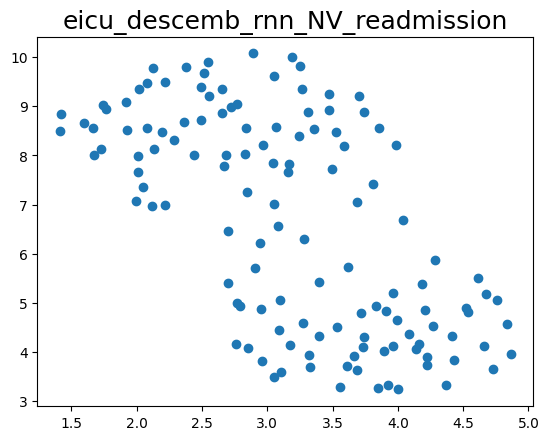

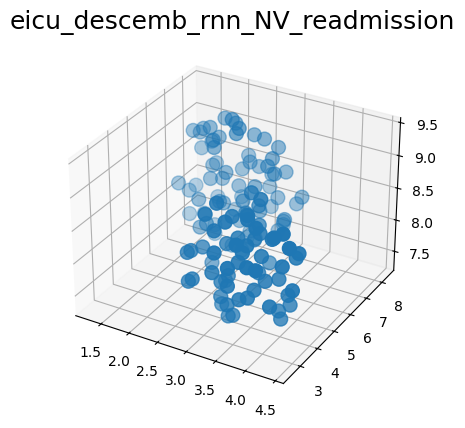

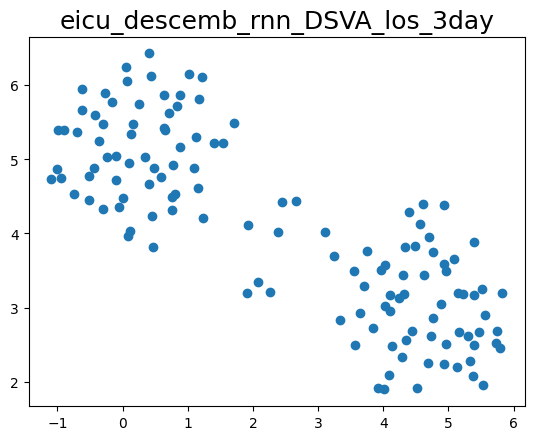

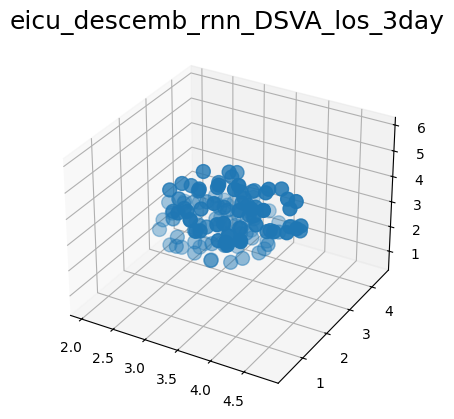

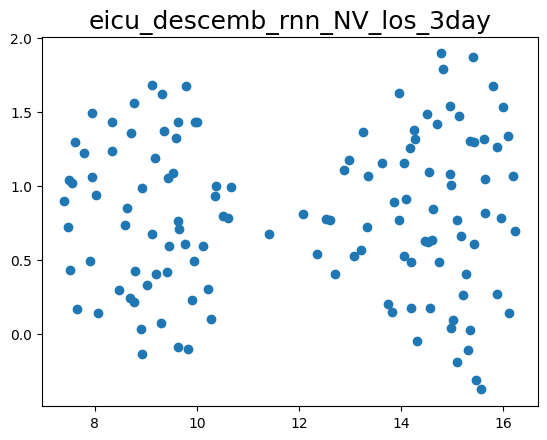

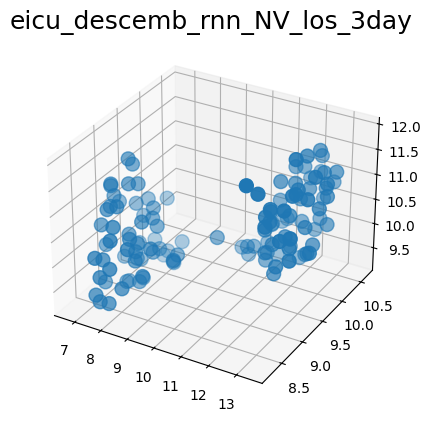

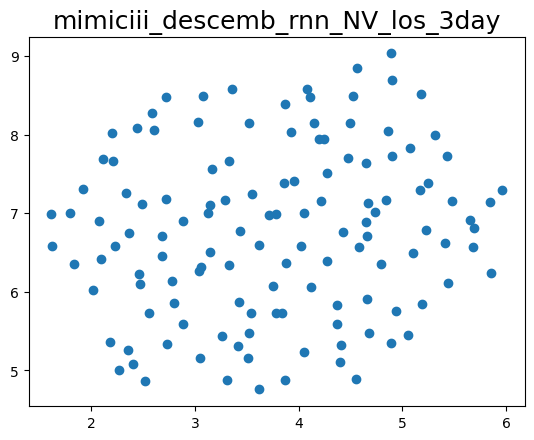

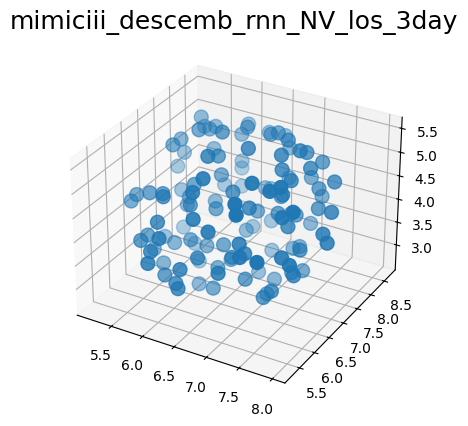

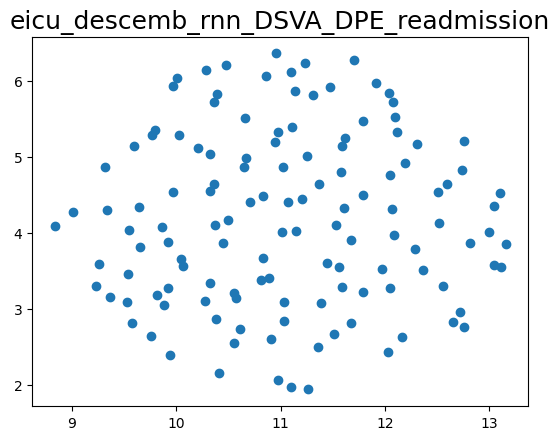

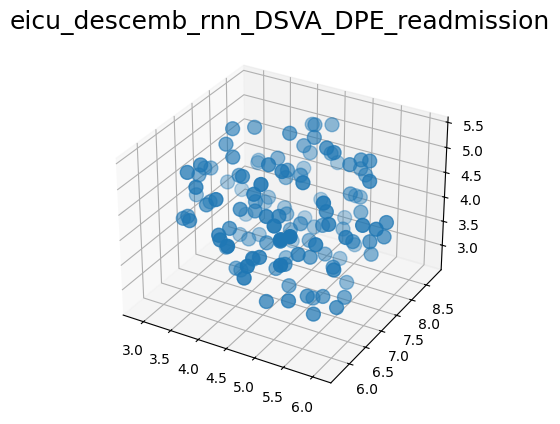

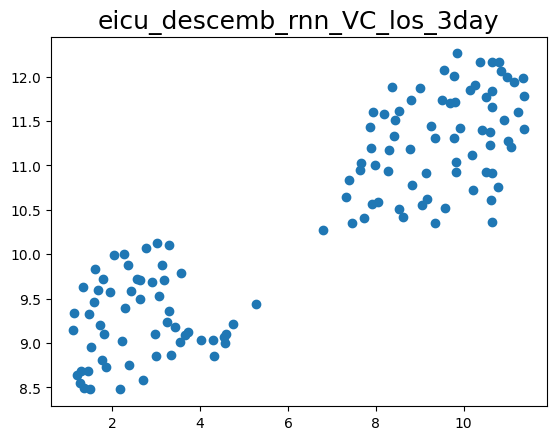

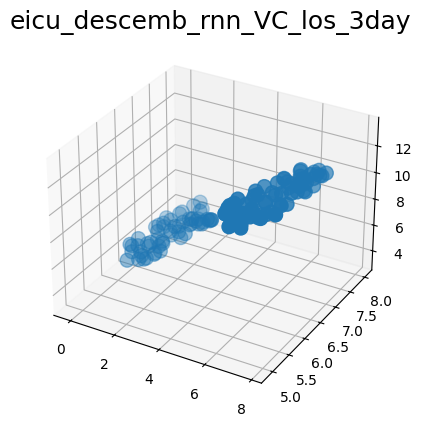

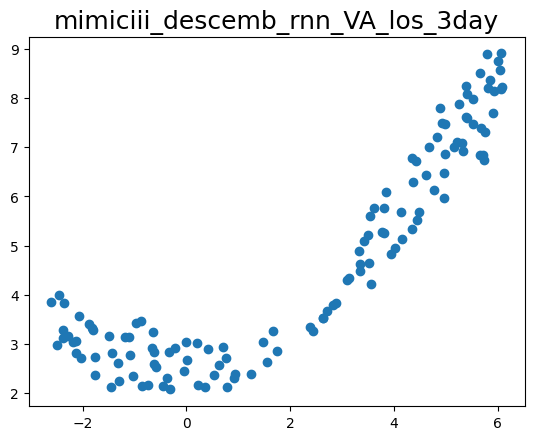

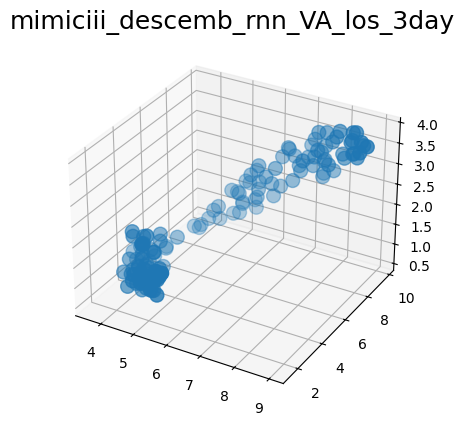

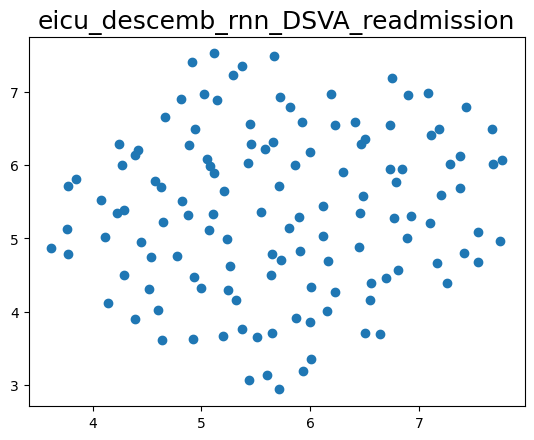

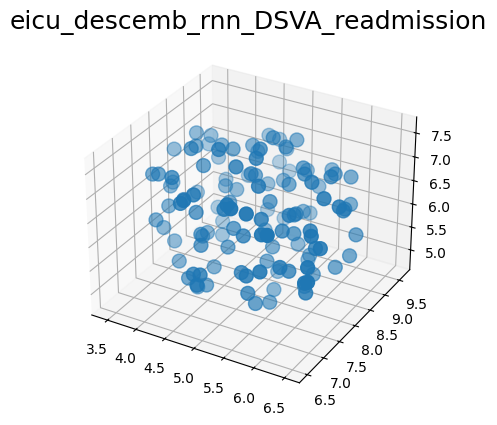

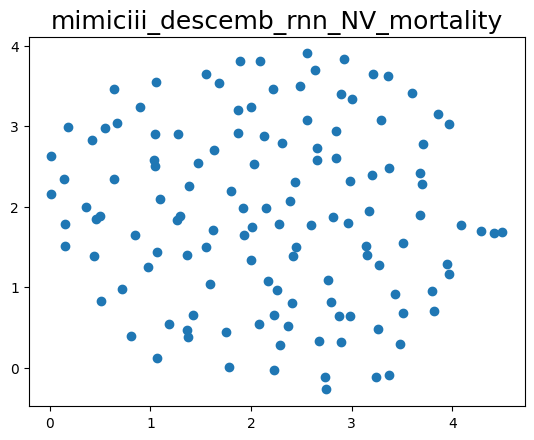

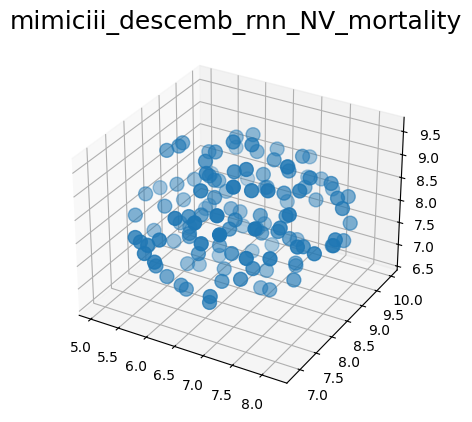

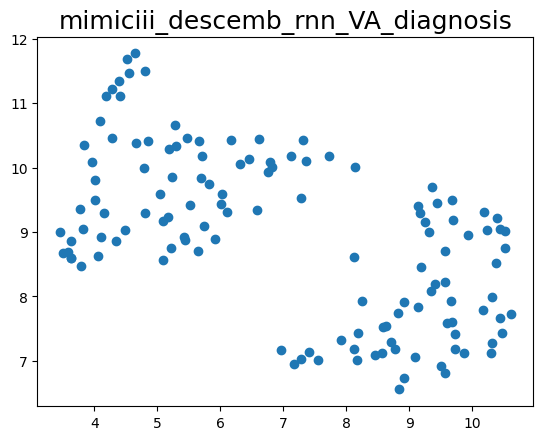

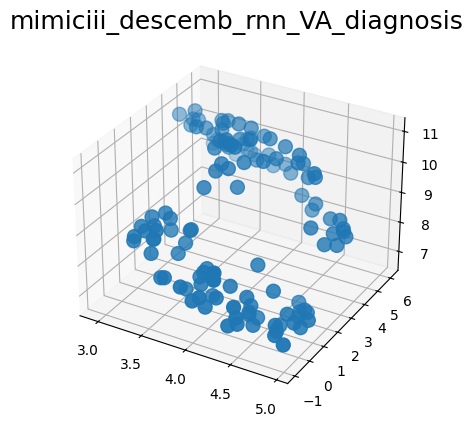

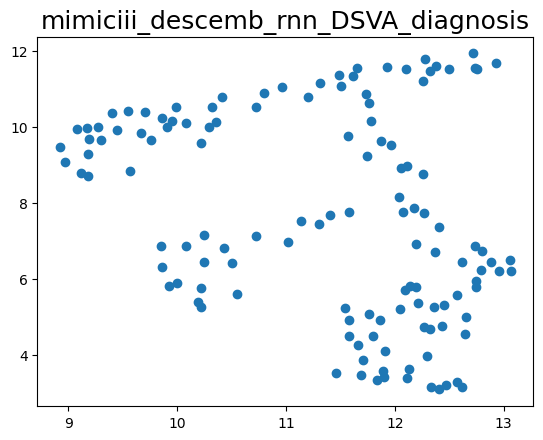

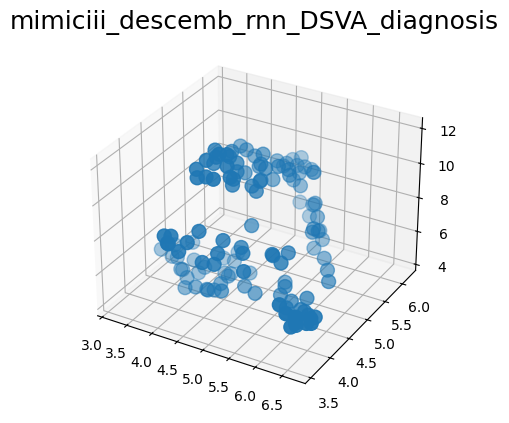

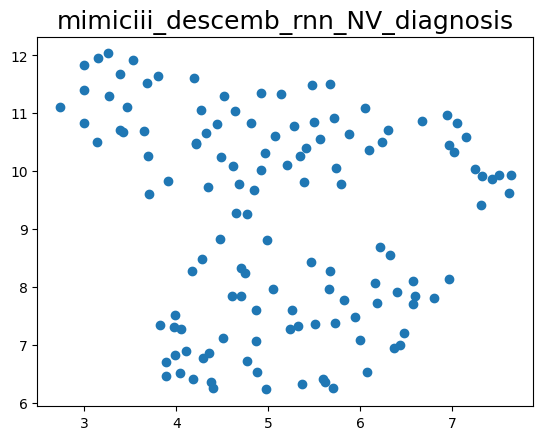

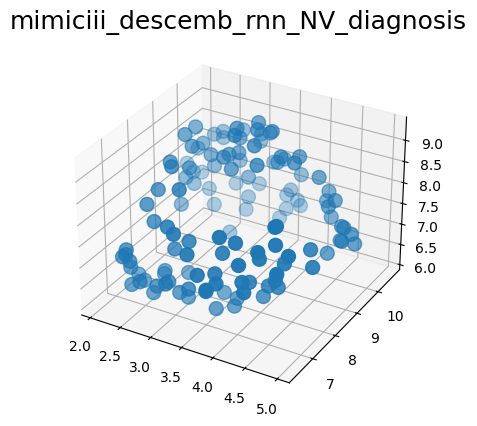

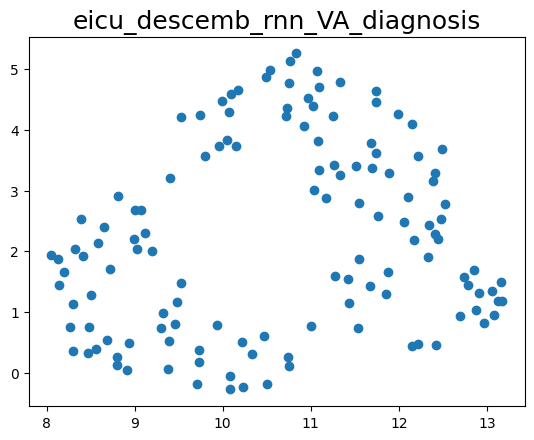

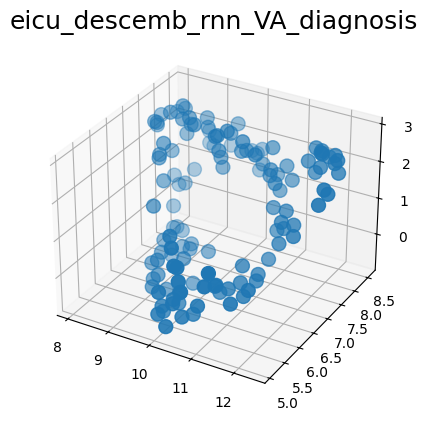

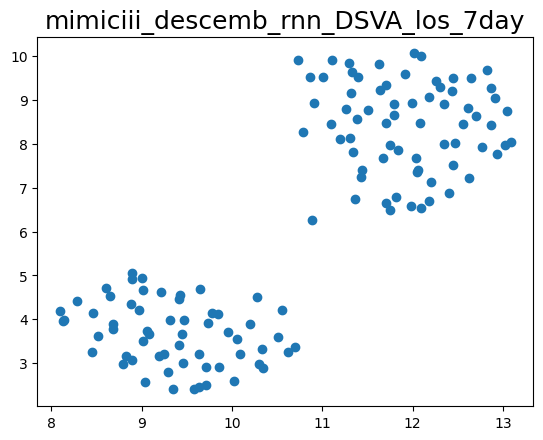

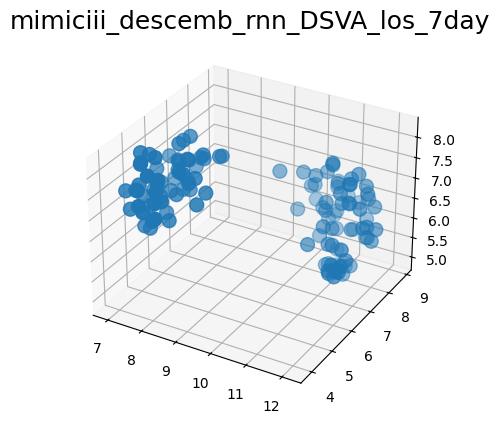

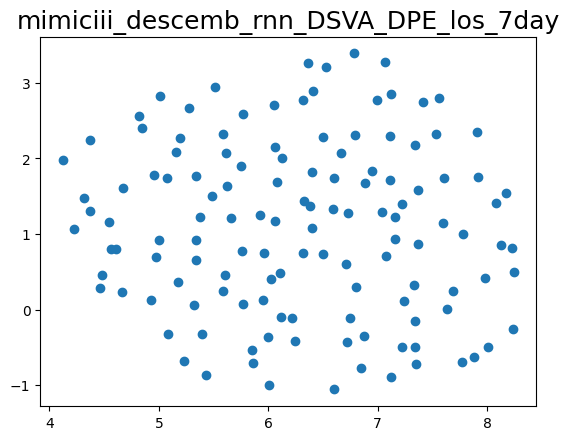

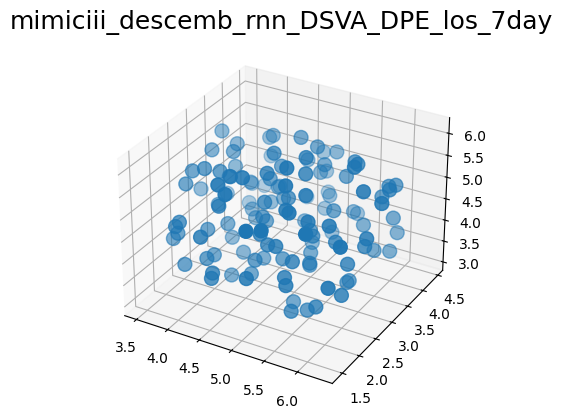

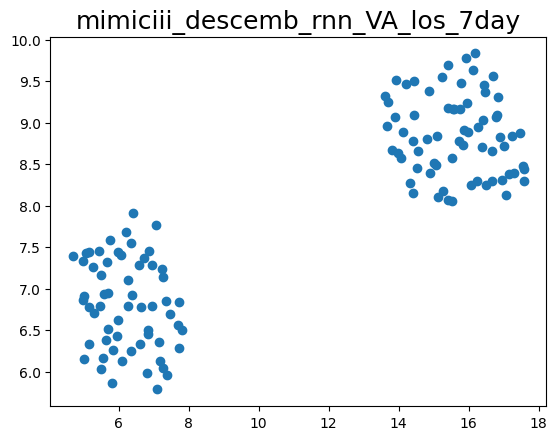

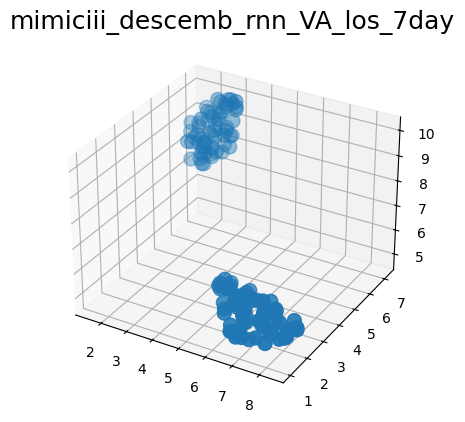

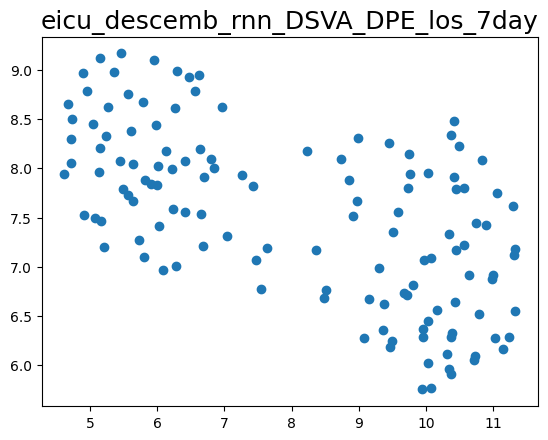

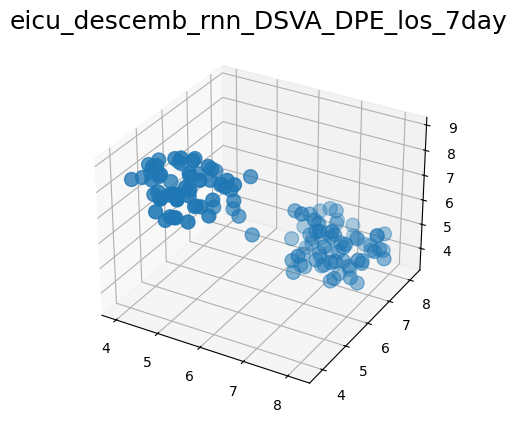

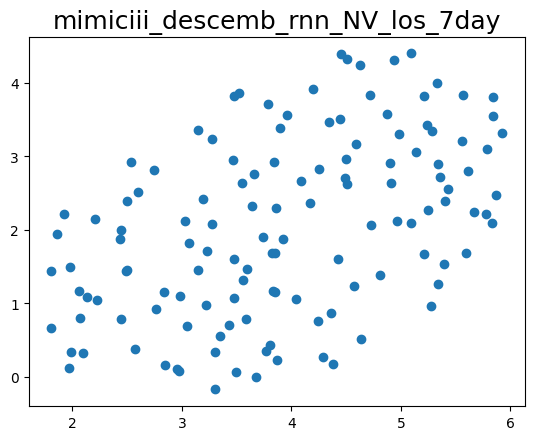

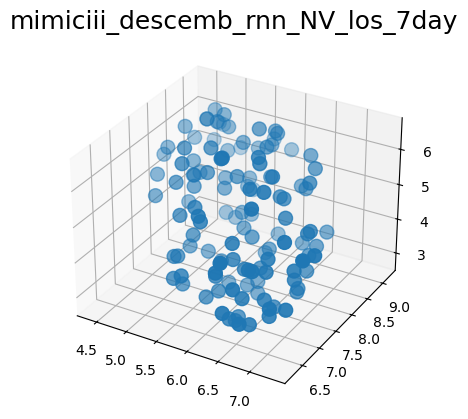

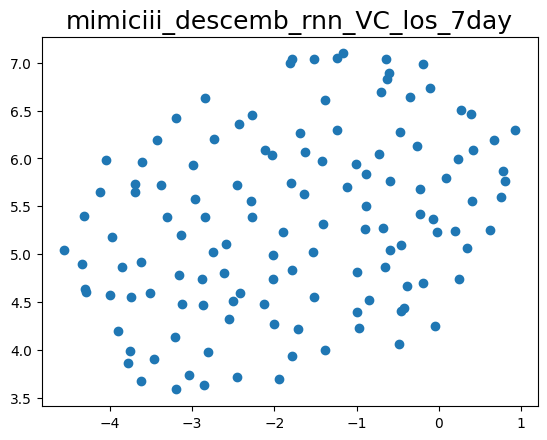

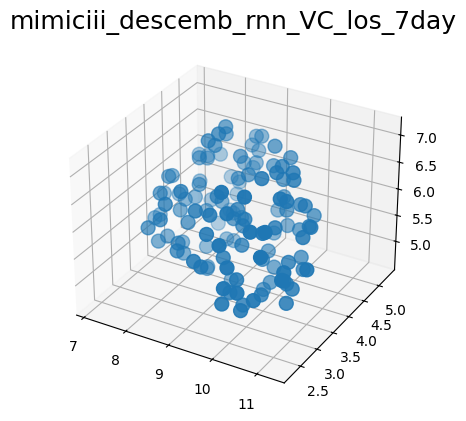

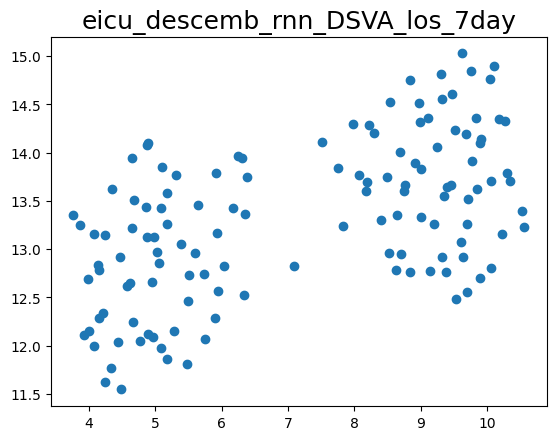

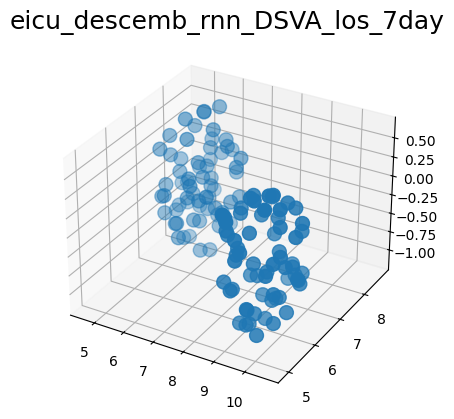

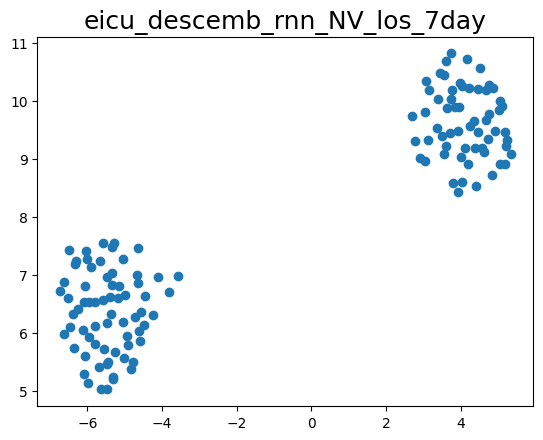

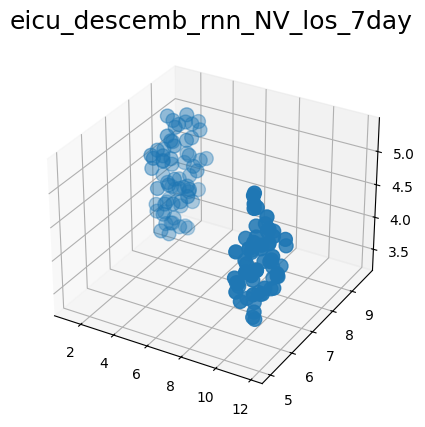

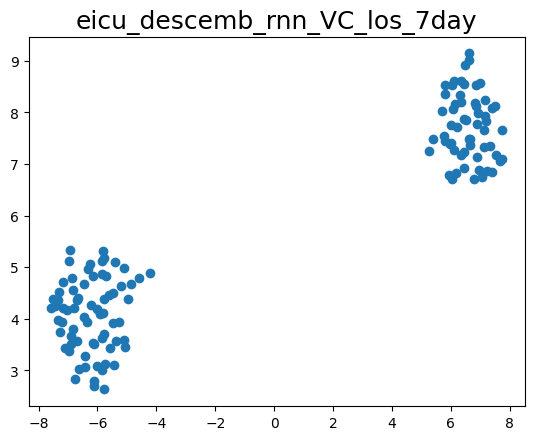

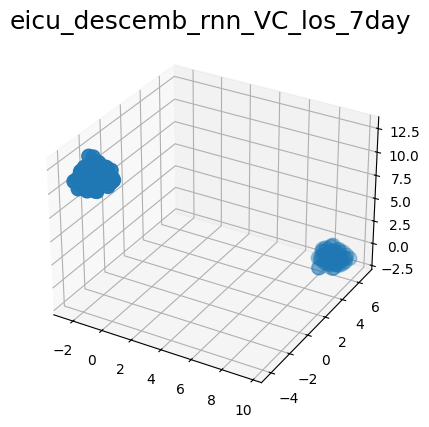

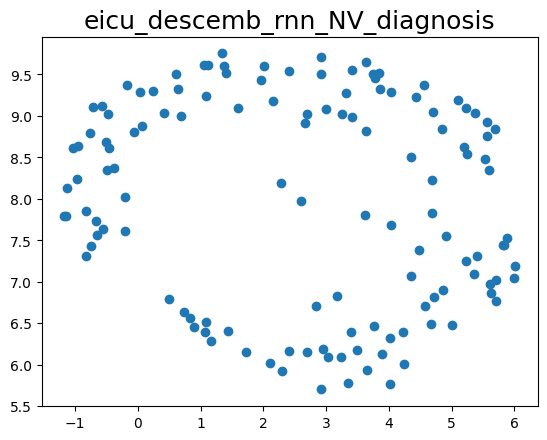

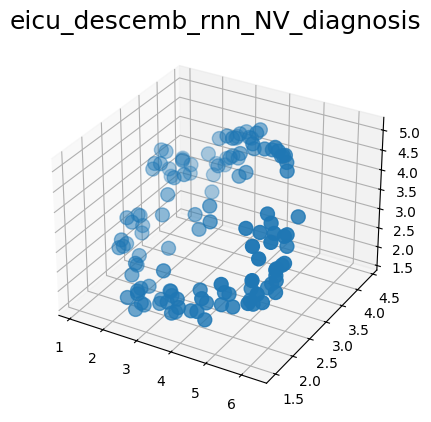

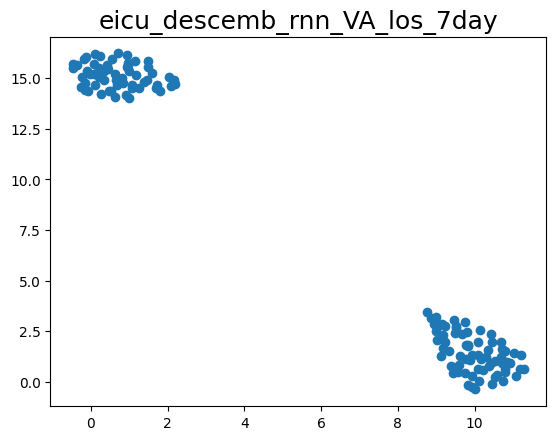

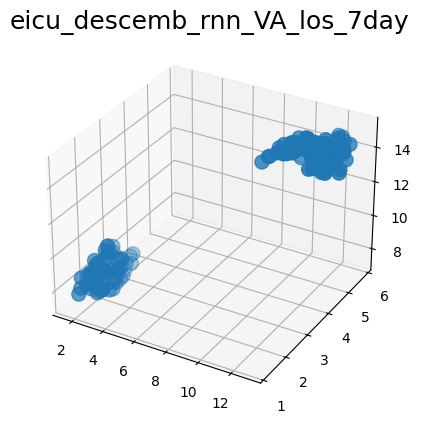

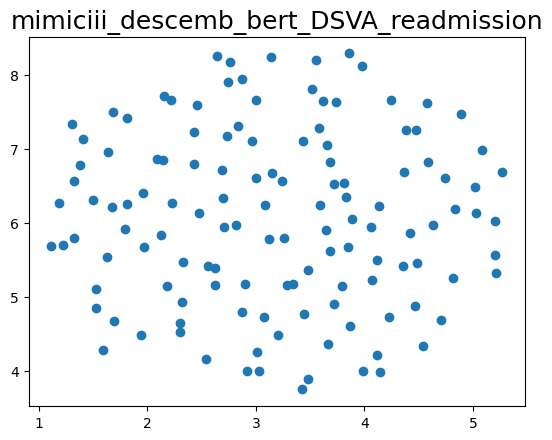

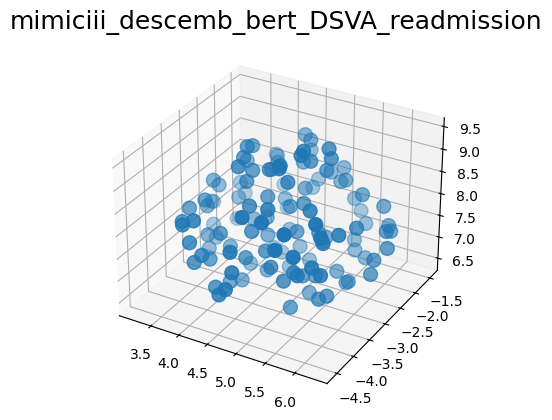

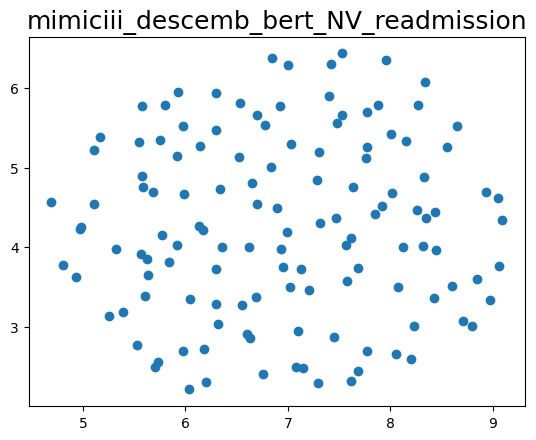

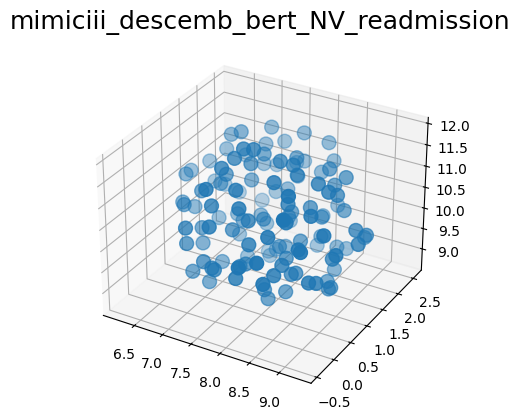

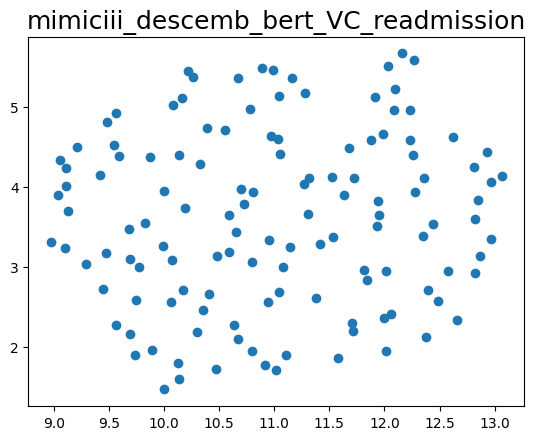

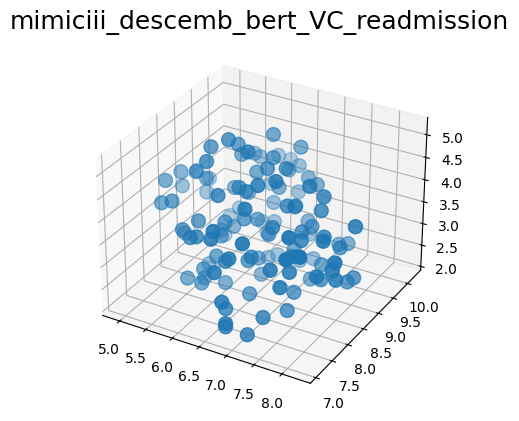

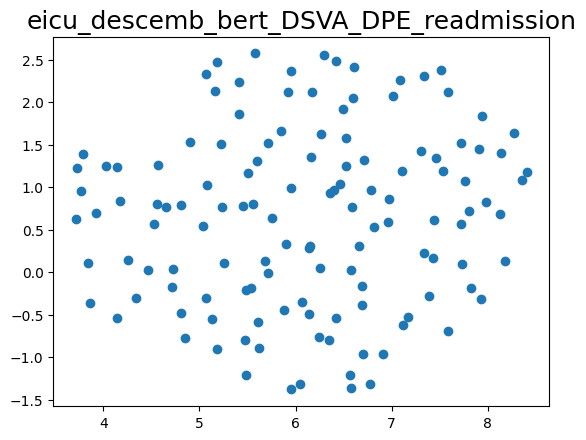

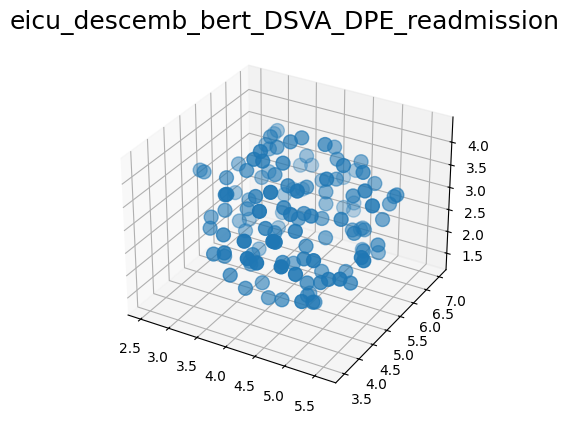

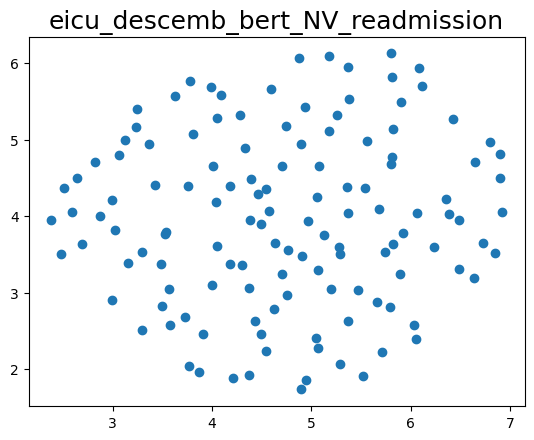

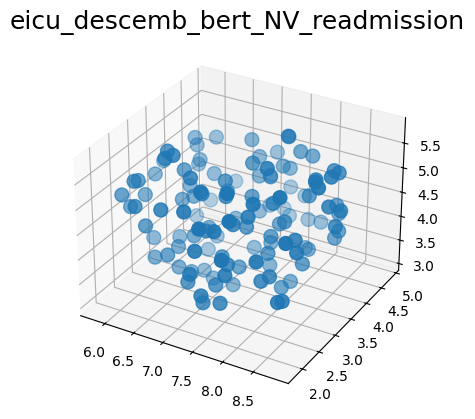

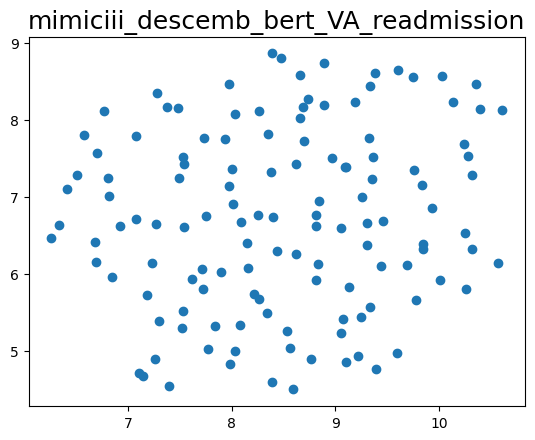

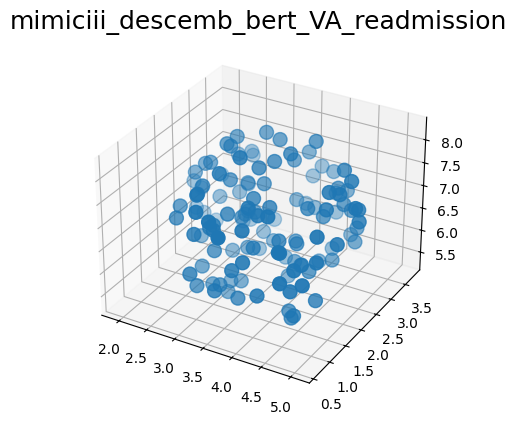

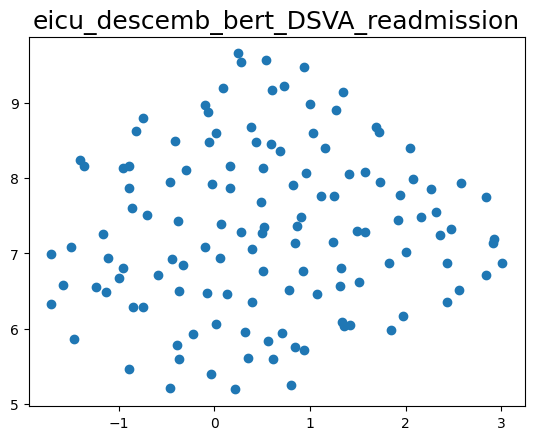

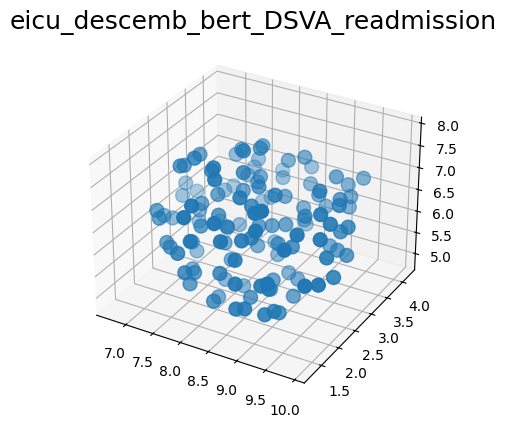

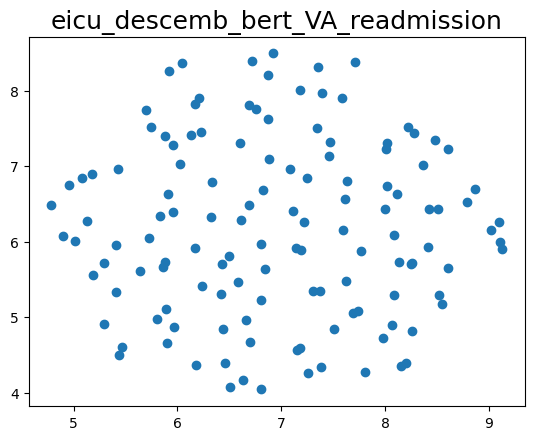

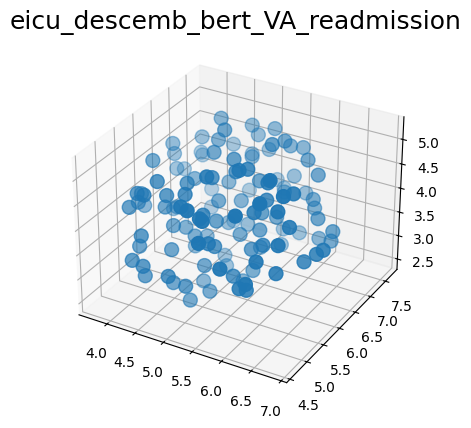

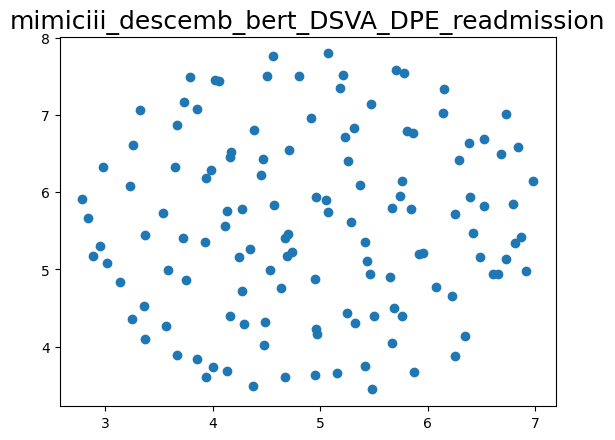

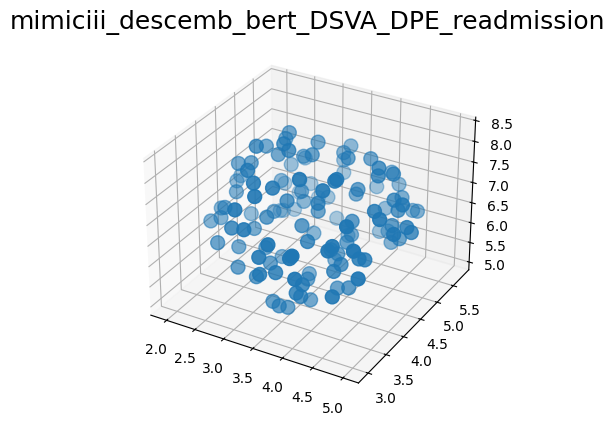

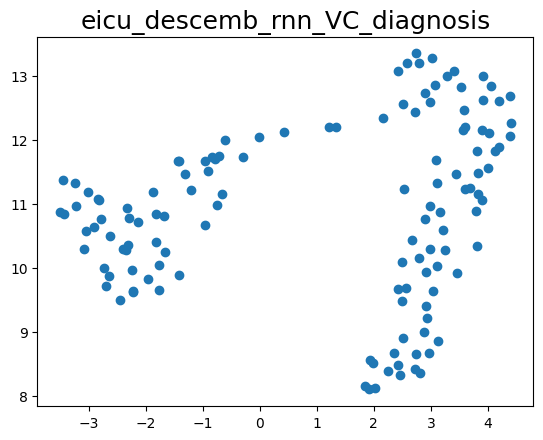

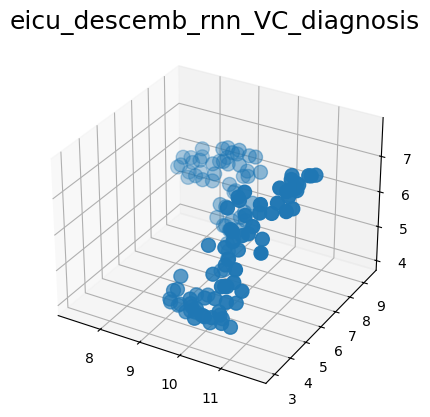

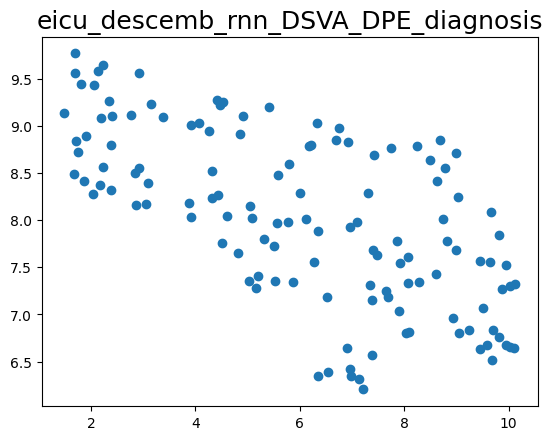

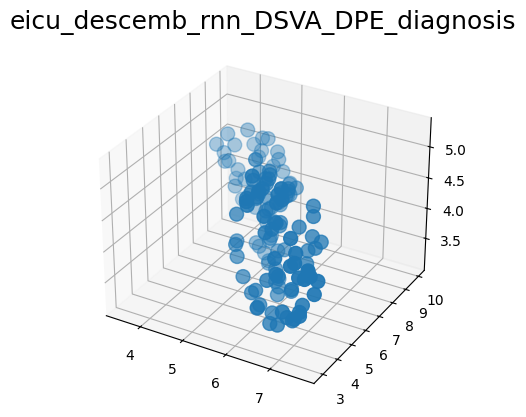

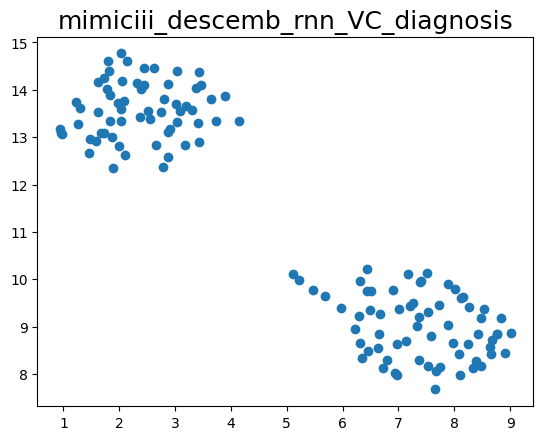

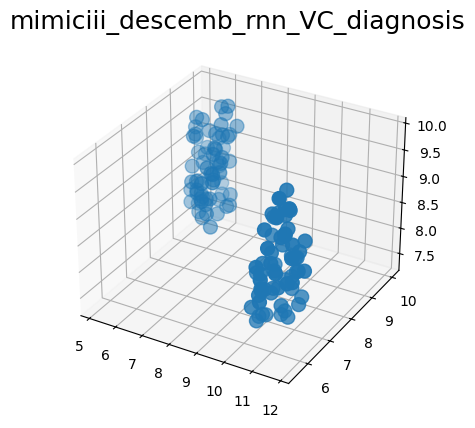

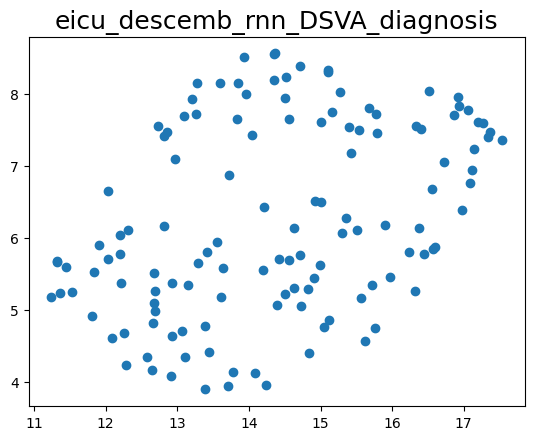

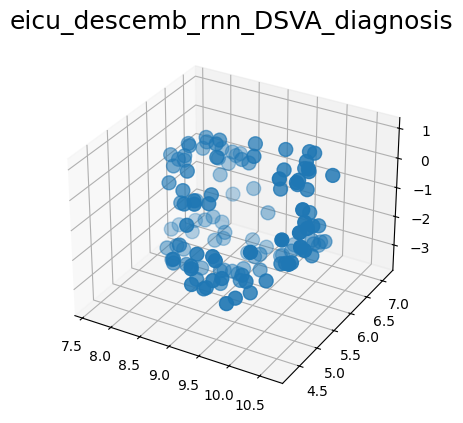

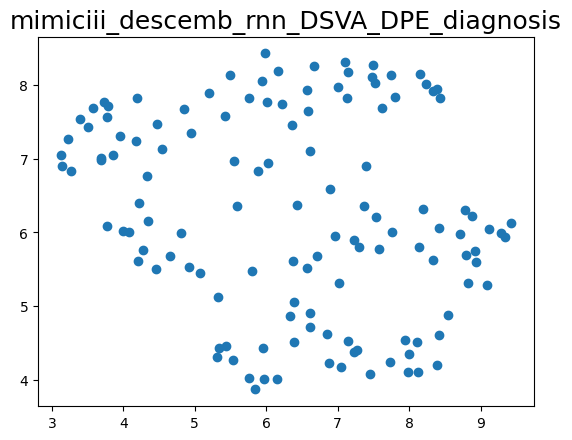

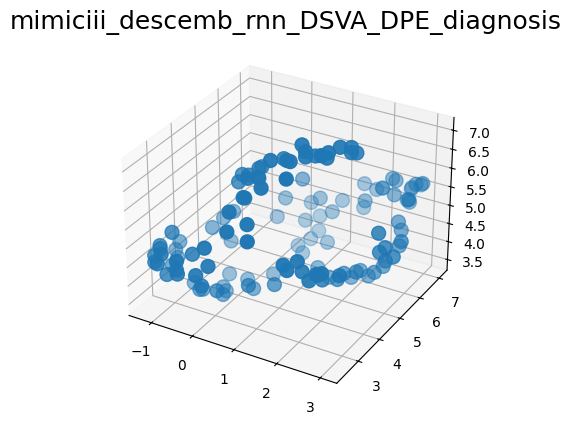

In [58]:
# plot_all_umaps()

In [57]:
finished_runs = df_experiments[df_experiments['done'] == True]
finished_runs.shape

(60, 8)

#### The dataloader from DescEmb to make dataset, collapsed for readability

In [38]:
import yaml
from types import SimpleNamespace

def parse_config(path):
    # Parse config and return variables in dict
    with open(path, 'r') as stream:
        config = yaml.safe_load(stream)
    config['input_path']  ='/Users/dsanchez/Documents/MCSIllinois/output'
    config["valid_subsets"] = 'valid, test'
    args = SimpleNamespace(**config)
    return args

In [39]:
config = parse_config('/Users/dsanchez/Documents/MCSIllinois/dlh_project/project_code/DescEmb/outputs/2024-04-20/00-38-41/.config/config.yaml')

In [40]:
from project_code.DescEmb.trainers import Trainer, Word2VecTrainer
import torch.multiprocessing as mp
import random

def get_trainer(config_path): 
    args = parse_config(config_path)

    args.device_ids = list(range(args.distributed_world_size))
    args.valid_subsets = (
        args.valid_subsets.replace(' ','').split(',')
        if (
            not args.disable_validation
            and args.task not in ['mlm', 'w2v']
            and args.valid_subsets
        )
        else []
    )
    mp.set_sharing_strategy('file_system')
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True

    if args.task != 'w2v':
        trainer = Trainer(args)
    else:
        trainer = Word2VecTrainer(args)
    
    return trainer


word2vec.py
codeemb.py
__init__.py
__pycache__
ehr_model.py
rnn.py
descemb.py


In [42]:
trainer = get_trainer('/Users/dsanchez/Documents/MCSIllinois/dlh_project/project_code/DescEmb/outputs/2024-04-20/00-38-41/.config/config.yaml')

/Users/dsanchez/Documents/MCSIllinois/dlh_project/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


/Users/dsanchez/Documents/MCSIllinois/output/mimiciii/fold/fold_split_1.csv
/Users/dsanchez/Documents/MCSIllinois/output/mimiciii/fold/fold_split_1.csv
/Users/dsanchez/Documents/MCSIllinois/output/mimiciii/fold/fold_split_1.csv


In [43]:
trainer.model

EHRModel(
  (embed_model): RNNTextEncoder(
    (subword_embed_layer): SubwordInputLayer(
      (embedding): Embedding(28996, 128, padding_idx=0)
    )
    (model): GRU(128, 256, batch_first=True, dropout=0.3, bidirectional=True)
    (post_encode_proj): Linear(in_features=512, out_features=128, bias=True)
  )
  (pred_model): RNNModel(
    (model): GRU(128, 256, batch_first=True, dropout=0.3)
    (final_proj): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [44]:
dataloaders = trainer.data_loaders
trainloader = dataloaders['train']

labels = trainloader.dataset.label
data = trainloader.dataset.value
# data =  trainloader.dataset.input_ids

In [46]:
from project_code.DescEmb.trainers import Trainer

import torch.multiprocessing as mp
from project_code.DescEmb import models
import random

def get_model(config_path, checkpoint_path): 
    args = parse_config(config_path)

    model_type = args.model
    
    if model_type == 'descemb_rnn':
        model = models.descemb.RNNTextEncoder(args)
    elif model_type == 'descemb_bert':
        model = models.descemb.BertTextEncoder(args)
    elif model_type == 'codeemb':
        model = models.codemb.DescEmb_RNN(args)
    elif model_type == 'ehr_model':
        model = models.ehr_model.EHRModel(args)
        
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model_state_dict = checkpoint['model_state_dict']

    # Load the model state dict
    model.load_state_dict(model_state_dict)

    # Set the model to evaluation mode
    model.eval()
    
    
    return model


In [47]:
# Function to extract embeddings
def extract_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            embedded = model.embed_model.subword_embed_layer(inputs)
            embedded_flat = embedded.view(embedded.size(0), -1)
            embeddings.append(embedded_flat)
            labels.extend(targets.tolist())
    embeddings = torch.cat(embeddings, dim=0).numpy()
    return embeddings, labels

In [56]:
finished_runs = df_experiments[df_experiments['done'] == True]
for i in range(finished_runs.shape[0]):
    experiment = finished_runs.iloc[i]
    run_path = experiment['run']
    
    # Loading in model
    checkpoint_path = os.path.join(run_path, 'checkpoints/checkpoint_best.pt')
    config_path = os.path.join(run_path, '.config/config.yaml')
    model = get_model(config_path, checkpoint_path)
    
    # Getting trainer
    trainer = get_trainer(config_path)
    dataloaders = trainer.data_loaders
    trainloader = dataloaders['train']
    
    # Get labels and ata from dataloader
    labels = trainloader.dataset.label
    data = trainloader.dataset.value
    
    # Forward pass to obtain embeddings
    # with torch.no_grad():
    #     # Assuming 'embedding_layer' is the layer from which you want to extract embeddings
    #     embeddings = model.embed_model(data)
    
    # embeddings = checkpoint['model_state_dict']['embed_model.post_emdeb_proj.weight']
    umap_embeddings = umap.UMAP(n_components=2, random_state=42).fit_transform(data)
    
    # Plot embeddings
    plt.figure(figsize=(10, 8))
    plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], color='b', label='Embeddings')
    for i in range(len(data)):
        x, y = umap_embeddings[i]
        color = 'b' if (labels[i] > 0) else 'r'

        plt.scatter(x, y, color=color)
        plt.figure(figsize=(10, 8))

    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.title('Embedding Space Visualization')
    plt.show()
    
    break

/Users/dsanchez/Documents/MCSIllinois/dlh_project/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


/Users/dsanchez/Documents/MCSIllinois/output/eicu/fold/fold_split_1.csv
/Users/dsanchez/Documents/MCSIllinois/output/eicu/fold/fold_split_1.csv
/Users/dsanchez/Documents/MCSIllinois/output/eicu/fold/fold_split_1.csv


KeyboardInterrupt: 

In [ ]:
embedding_layer = model.embedding_layer
embeddings = embedding_layer.weight.data.numpy()
labels = ['0', '1']
umap_embeddings = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings)
# Plot embeddings
plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    x, y = umap_embeddings[i]
    plt.scatter(x, y, color='b')
    plt.text(x, y, label, fontsize=9)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('Embedding Space Visualization')
plt.show()

NameError: name 'model' is not defined

In [ ]:
/Users/dsanchez/Documents/MCSIllinois/dlh_project/project_code/DescEmb/outputs/2024-04-20/05-34-59/.config/config.yamlmodel

get_model('/Users/dsanchez/Documents/MCSIllinois/dlh_project/project_code/DescEmb/outputs/2024-04-20/02-31-44/.config/config.yaml')

/Users/dsanchez/Documents/MCSIllinois/dlh_project/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


AttributeError: 'types.SimpleNamespace' object has no attribute 'run'

In [ ]:
from project_code.DescEmb import models

args = parse_config('/Users/dsanchez/Documents/MCSIllinois/dlh_project/project_code/DescEmb/outputs/2024-04-20/02-31-44/.config/config.yaml')

models.descemb.RNNTextEncoder(args)



/Users/dsanchez/Documents/MCSIllinois/dlh_project/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


RNNTextEncoder(
  (subword_embed_layer): SubwordInputLayer(
    (embedding): Embedding(28996, 128, padding_idx=0)
  )
  (model): GRU(128, 256, batch_first=True, dropout=0.3, bidirectional=True)
  (post_encode_proj): Linear(in_features=512, out_features=128, bias=True)
)

In [ ]:
mimic_results = [
    # CodeEmb Data
    ['DX', 'VA', 'CodeEmb', 'RD', '.726'],
    ['DX', 'VA', 'CodeEmb', 'W2V', '.704'],
    ['DX', 'DSVS', 'CodeEmb', 'RD', '.726'],
    ['DX', 'DSVA', 'CodeEmb', 'W2V', '.704'],
    ['DX', 'DSVA+DPE', 'CodeEmb', 'RD', '-'],
    ['DX', 'DSVA+DPE', 'CodeEmb', 'W2V', '-'],
    ['DX', 'VC', 'CodeEmb', 'RD', '.757'],
    ['DX', 'VC', 'CodeEmb', 'W2V', '.751'],
    ['Mortality', 'VA', 'CodeEmb', 'RD', '.228'],
    ['Mortality', 'VA', 'CodeEmb', 'W2V', '.209'],
    ['Mortality', 'DSVS', 'CodeEmb', 'RD', '.228'],
    ['Mortality', 'DSVA', 'CodeEmb', 'W2V', '.209'],
    ['Mortality', 'DSVA+DPE', 'CodeEmb', 'RD', '-'],
    ['Mortality', 'DSVA+DPE', 'CodeEmb', 'W2V', '-'],
    ['Mortality', 'VC', 'CodeEmb', 'RD', '.313'],
    ['Mortality', 'VC', 'CodeEmb', 'W2V', '.334'],
    ['LOS>3', 'VA', 'CodeEmb', 'RD', '.582'],
    ['LOS>3', 'VA', 'CodeEmb', 'W2V', '.585'],
    ['LOS>3', 'DSVS', 'CodeEmb', 'RD', '.582'],
    ['LOS>3', 'DSVA', 'CodeEmb', 'W2V', '.585'],
    ['LOS>3', 'DSVA+DPE', 'CodeEmb', 'RD', '-'],
    ['LOS>3', 'DSVA+DPE', 'CodeEmb', 'W2V', '-'],
    ['LOS>3', 'VC', 'CodeEmb', 'RD', '.61'],
    ['LOS>3', 'VC', 'CodeEmb', 'W2V', '.614'],
    ['LOS>7', 'VA', 'CodeEmb', 'RD', '.269'],
    ['LOS>7', 'VA', 'CodeEmb', 'W2V', '.251'],
    ['LOS>7', 'DSVS', 'CodeEmb', 'RD', '.269'],
    ['LOS>7', 'DSVA', 'CodeEmb', 'W2V', '.251'],
    ['LOS>7', 'DSVA+DPE', 'CodeEmb', 'RD', '-'],
    ['LOS>7', 'DSVA+DPE', 'CodeEmb', 'W2V', '-'],
    ['LOS>7', 'VC', 'CodeEmb', 'RD', '.326'],
    ['LOS>7', 'VC', 'CodeEmb', 'W2V', '.342'],
    ['ReAdm', 'VA', 'CodeEmb', 'RD', '.044'],
    ['ReAdm', 'VA', 'CodeEmb', 'W2V', '.043'],
    ['ReAdm', 'DSVS', 'CodeEmb', 'RD', '.044'],
    ['ReAdm', 'DSVA', 'CodeEmb', 'W2V', '.043'],
    ['ReAdm', 'DSVA+DPE', 'CodeEmb', 'RD', '-'],
    ['ReAdm', 'DSVA+DPE', 'CodeEmb', 'W2V', '-'],
    ['ReAdm', 'VC', 'CodeEmb', 'RD', '.043'],
    ['ReAdm', 'VC', 'CodeEmb', 'W2V', '.043'],
    
    # DescEmb BERT Data
    ['DX', 'VA', 'DescEmb_BERT', 'CLS-FT', '.733'],
    ['DX', 'VA', 'DescEmb_BERT', 'FT', '.76'],
    ['DX', 'VA', 'DescEmb_BERT', 'Scr', '.747'],
    ['DX', 'VA', 'DescEmb_BERT', 'FT+MLM', '.767'],
    ['DX', 'DSVA', 'DescEmb_BERT', 'CLS-FT', '.731'],
    ['DX', 'DSVA', 'DescEmb_BERT', 'FT', '.77'],
    ['DX', 'DSVA', 'DescEmb_BERT', 'Scr', '.752'],
    ['DX', 'DSVA', 'DescEmb_BERT', 'FT+MLM', '.767'],
    ['DX', 'DSVA+DPE', 'DescEmb_BERT', 'CLS-FT', '-'],
    ['DX', 'DSVA+DPE', 'DescEmb_BERT', 'FT', '.771'],
    ['DX', 'DSVA+DPE', 'DescEmb_BERT', 'Scr', '.752'],
    ['DX', 'DSVA+DPE', 'DescEmb_BERT', 'FT+MLM', '.764'],
    ['DX', 'VC', 'DescEmb_BERT', 'CLS-FT', '752'],
    ['DX', 'VC', 'DescEmb_BERT', 'FT', '.756'],
    ['DX', 'VC', 'DescEmb_BERT', 'Scr', '.745'],
    ['DX', 'VC', 'DescEmb_BERT', 'FT+MLM', '.75'],   
    ['Mortality', 'VA', 'DescEmb_BERT', 'CLS-FT', '.346'],
    ['Mortality', 'VA', 'DescEmb_BERT', 'FT', '.343'],
    ['Mortality', 'VA', 'DescEmb_BERT', 'Scr', '.31'],
    ['Mortality', 'VA', 'DescEmb_BERT', 'FT+MLM', '.38'],
    ['Mortality', 'DSVA', 'DescEmb_BERT', 'CLS-FT', '.347'],
    ['Mortality', 'DSVA', 'DescEmb_BERT', 'FT', '.377'],
    ['Mortality', 'DSVA', 'DescEmb_BERT', 'Scr', '.378'],
    ['Mortality', 'DSVA', 'DescEmb_BERT', 'FT+MLM', '.379'],
    ['Mortality', 'DSVA+DPE', 'DescEmb_BERT', 'CLS-FT', '-'],
    ['Mortality', 'DSVA+DPE', 'DescEmb_BERT', 'FT', '.378'],
    ['Mortality', 'DSVA+DPE', 'DescEmb_BERT', 'Scr', '.372'],
    ['Mortality', 'DSVA+DPE', 'DescEmb_BERT', 'FT+MLM', '.383'],
    ['Mortality', 'VC', 'DescEmb_BERT', 'CLS-FT', '339'],
    ['Mortality', 'VC', 'DescEmb_BERT', 'FT', '.336'],
    ['Mortality', 'VC', 'DescEmb_BERT', 'Scr', '.335'],
    ['Mortality', 'VC', 'DescEmb_BERT', 'FT+MLM', '.379'],
    ['LOS>3', 'VA', 'DescEmb_BERT', 'CLS-FT', '.608'],
    ['LOS>3', 'VA', 'DescEmb_BERT', 'FT', '.616'],
    ['LOS>3', 'VA', 'DescEmb_BERT', 'Scr', '.601'],
    ['LOS>3', 'VA', 'DescEmb_BERT', 'FT+MLM', '.616'],
    ['LOS>3', 'DSVA', 'DescEmb_BERT', 'CLS-FT', '.608'],
    ['LOS>3', 'DSVA', 'DescEmb_BERT', 'FT', '.624'],
    ['LOS>3', 'DSVA', 'DescEmb_BERT', 'Scr', '.617'],
    ['LOS>3', 'DSVA', 'DescEmb_BERT', 'FT+MLM', '.619'],
    ['LOS>3', 'DSVA+DPE', 'DescEmb_BERT', 'CLS-FT', '-'],
    ['LOS>3', 'DSVA+DPE', 'DescEmb_BERT', 'FT', '.624'],
    ['LOS>3', 'DSVA+DPE', 'DescEmb_BERT', 'Scr', '.616'],
    ['LOS>3', 'DSVA+DPE', 'DescEmb_BERT', 'FT+MLM', '.622'],
    ['LOS>3', 'VC', 'DescEmb_BERT', 'CLS-FT', '616'],
    ['LOS>3', 'VC', 'DescEmb_BERT', 'FT', '.61'],
    ['LOS>3', 'VC', 'DescEmb_BERT', 'Scr', '.614'],
    ['LOS>3', 'VC', 'DescEmb_BERT', 'FT+MLM', '.612'],
    ['LOS>7', 'VA', 'DescEmb_BERT', 'CLS-FT', '.346'],
    ['LOS>7', 'VA', 'DescEmb_BERT', 'FT', '.338'],
    ['LOS>7', 'VA', 'DescEmb_BERT', 'Scr', '.325'],
    ['LOS>7', 'VA', 'DescEmb_BERT', 'FT+MLM', '.342'],
    ['LOS>7', 'DSVA', 'DescEmb_BERT', 'CLS-FT', '.348'],
    ['LOS>7', 'DSVA', 'DescEmb_BERT', 'FT', '.355'],
    ['LOS>7', 'DSVA', 'DescEmb_BERT', 'Scr', '.359'],
    ['LOS>7', 'DSVA', 'DescEmb_BERT', 'FT+MLM', '.356'],
    ['LOS>7', 'DSVA+DPE', 'DescEmb_BERT', 'CLS-FT', '-'],
    ['LOS>7', 'DSVA+DPE', 'DescEmb_BERT', 'FT', '.36'],
    ['LOS>7', 'DSVA+DPE', 'DescEmb_BERT', 'Scr', '.359'],
    ['LOS>7', 'DSVA+DPE', 'DescEmb_BERT', 'FT+MLM', '.353'],
    ['LOS>7', 'VC', 'DescEmb_BERT', 'CLS-FT', '346'],
    ['LOS>7', 'VC', 'DescEmb_BERT', 'FT', '.341'],
    ['LOS>7', 'VC', 'DescEmb_BERT', 'Scr', '.339'],
    ['LOS>7', 'VC', 'DescEmb_BERT', 'FT+MLM', '.344'],
    ['ReAdm', 'VA', 'DescEmb_BERT', 'CLS-FT', '.042'],
    ['ReAdm', 'VA', 'DescEmb_BERT', 'FT', '.042'],
    ['ReAdm', 'VA', 'DescEmb_BERT', 'Scr', '.045'],
    ['ReAdm', 'VA', 'DescEmb_BERT', 'FT+MLM', '.044'],
    ['ReAdm', 'DSVA', 'DescEmb_BERT', 'CLS-FT', '.041'],
    ['ReAdm', 'DSVA', 'DescEmb_BERT', 'FT', '.043'],
    ['ReAdm', 'DSVA', 'DescEmb_BERT', 'Scr', '.046'],
    ['ReAdm', 'DSVA', 'DescEmb_BERT', 'FT+MLM', '.044'],
    ['ReAdm', 'DSVA+DPE', 'DescEmb_BERT', 'CLS-FT', '-'],
    ['ReAdm', 'DSVA+DPE', 'DescEmb_BERT', 'FT', '.043'],
    ['ReAdm', 'DSVA+DPE', 'DescEmb_BERT', 'Scr', '.046'],
    ['ReAdm', 'DSVA+DPE', 'DescEmb_BERT', 'FT+MLM', '.044'],
    ['ReAdm', 'VC', 'DescEmb_BERT', 'CLS-FT', '044'],
    ['ReAdm', 'VC', 'DescEmb_BERT', 'FT', '.045'],
    ['ReAdm', 'VC', 'DescEmb_BERT', 'Scr', '.047'],
    ['ReAdm', 'VC', 'DescEmb_BERT', 'FT+MLM', '.044'],
    
    # DescEmb RNN Data
    ['DX', 'VA', 'DescEmb_RNN', 'Scr', '.767'],
    ['DX', 'VA', 'DescEmb_RNN', 'Scr+MLM', '.762'],
    ['DX', 'DSVS', 'DescEmb_RNN', 'Scr', '.77'],
    ['DX', 'DSVA', 'DescEmb_RNN', 'Scr+MLM', '.766'],
    ['DX', 'DSVA+DPE', 'DescEmb_RNN', 'Scr', '.768'],
    ['DX', 'DSVA+DPE', 'DescEmb_RNN', 'Scr+MLM', '.763'],
    ['DX', 'VC', 'DescEmb_RNN', 'Scr', '.755'],
    ['DX', 'VC', 'DescEmb_RNN', 'Scr+MLM', '.753'],
    ['Mortality', 'VA', 'DescEmb_RNN', 'Scr', '.383'],
    ['Mortality', 'VA', 'DescEmb_RNN', 'Scr+MLM', '.398'],
    ['Mortality', 'DSVS', 'DescEmb_RNN', 'Scr', '.394'],
    ['Mortality', 'DSVA', 'DescEmb_RNN', 'Scr+MLM', '.39'],
    ['Mortality', 'DSVA+DPE', 'DescEmb_RNN', 'Scr', '.4'],
    ['Mortality', 'DSVA+DPE', 'DescEmb_RNN', 'Scr+MLM', '.393'],
    ['Mortality', 'VC', 'DescEmb_RNN', 'Scr', '.344'],
    ['Mortality', 'VC', 'DescEmb_RNN', 'Scr+MLM', '.338'],
    ['LOS>3', 'VA', 'DescEmb_RNN', 'Scr', '.624'],
    ['LOS>3', 'VA', 'DescEmb_RNN', 'Scr+MLM', '.63'],
    ['LOS>3', 'DSVS', 'DescEmb_RNN', 'Scr', '.631'],
    ['LOS>3', 'DSVA', 'DescEmb_RNN', 'Scr+MLM', '.632'],
    ['LOS>3', 'DSVA+DPE', 'DescEmb_RNN', 'Scr', '.634'],
    ['LOS>3', 'DSVA+DPE', 'DescEmb_RNN', 'Scr+MLM', '628'],
    ['LOS>3', 'VC', 'DescEmb_RNN', 'Scr', '.622'],
    ['LOS>3', 'VC', 'DescEmb_RNN', 'Scr+MLM', '.622'],
    ['LOS>7', 'VA', 'DescEmb_RNN', 'Scr', '.349'],
    ['LOS>7', 'VA', 'DescEmb_RNN', 'Scr+MLM', '.349'],
    ['LOS>7', 'DSVS', 'DescEmb_RNN', 'Scr', '.35'],
    ['LOS>7', 'DSVA', 'DescEmb_RNN', 'Scr+MLM', '.35'],
    ['LOS>7', 'DSVA+DPE', 'DescEmb_RNN', 'Scr', '.352'],
    ['LOS>7', 'DSVA+DPE', 'DescEmb_RNN', 'Scr+MLM', '.353'],
    ['LOS>7', 'VC', 'DescEmb_RNN', 'Scr', '.347'],
    ['LOS>7', 'VC', 'DescEmb_RNN', 'Scr+MLM', '.352'],
    ['ReAdm', 'VA', 'DescEmb_RNN', 'Scr', '.044'],
    ['ReAdm', 'VA', 'DescEmb_RNN', 'Scr+MLM', '.043'],
    ['ReAdm', 'DSVS', 'DescEmb_RNN', 'Scr', '.045'],
    ['ReAdm', 'DSVA', 'DescEmb_RNN', 'Scr+MLM', '.044'],
    ['ReAdm', 'DSVA+DPE', 'DescEmb_RNN', 'Scr', '.041'],
    ['ReAdm', 'DSVA+DPE', 'DescEmb_RNN', 'Scr+MLM', '.044'],
    ['ReAdm', 'VC', 'DescEmb_RNN', 'Scr', '.044'],
    ['ReAdm', 'VC', 'DescEmb_RNN', 'Scr+MLM', '.044'],
]

eicu_results = [
    # CodeEmb Data
    ['DX', 'VA', 'CodeEmb', 'RD', '.447'],
    ['DX', 'VA', 'CodeEmb', 'W2V', '.422'],
    ['DX', 'DSVS', 'CodeEmb', 'RD', '.447'],
    ['DX', 'DSVA', 'CodeEmb', 'W2V', '.433'],
    ['DX', 'DSVA+DPE', 'CodeEmb', 'RD', '-'],
    ['DX', 'DSVA+DPE', 'CodeEmb', 'W2V', '-'],
    ['DX', 'VC', 'CodeEmb', 'RD', '.562'],
    ['DX', 'VC', 'CodeEmb', 'W2V', '.549'],
    ['Mortality', 'VA', 'CodeEmb', 'RD', '.112'],
    ['Mortality', 'VA', 'CodeEmb', 'W2V', '.153'],
    ['Mortality', 'DSVS', 'CodeEmb', 'RD', '.112'],
    ['Mortality', 'DSVA', 'CodeEmb', 'W2V', '.153'],
    ['Mortality', 'DSVA+DPE', 'CodeEmb', 'RD', '-'],
    ['Mortality', 'DSVA+DPE', 'CodeEmb', 'W2V', '-'],
    ['Mortality', 'VC', 'CodeEmb', 'RD', '.24'],
    ['Mortality', 'VC', 'CodeEmb', 'W2V', '.239'],
    ['LOS>3', 'VA', 'CodeEmb', 'RD', '.47'],
    ['LOS>3', 'VA', 'CodeEmb', 'W2V', '.439'],
    ['LOS>3', 'DSVS', 'CodeEmb', 'RD', '.47'],
    ['LOS>3', 'DSVA', 'CodeEmb', 'W2V', '.439'],
    ['LOS>3', 'DSVA+DPE', 'CodeEmb', 'RD', '-'],
    ['LOS>3', 'DSVA+DPE', 'CodeEmb', 'W2V', '-'],
    ['LOS>3', 'VC', 'CodeEmb', 'RD', '.525'],
    ['LOS>3', 'VC', 'CodeEmb', 'W2V', '.525'],
    ['LOS>7', 'VA', 'CodeEmb', 'RD', '.157'],
    ['LOS>7', 'VA', 'CodeEmb', 'W2V', '.184'],
    ['LOS>7', 'DSVS', 'CodeEmb', 'RD', '.157'],
    ['LOS>7', 'DSVA', 'CodeEmb', 'W2V', '.184'],
    ['LOS>7', 'DSVA+DPE', 'CodeEmb', 'RD', '-'],
    ['LOS>7', 'DSVA+DPE', 'CodeEmb', 'W2V', '-'],
    ['LOS>7', 'VC', 'CodeEmb', 'RD', '.231'],
    ['LOS>7', 'VC', 'CodeEmb', 'W2V', '.228'],
    ['ReAdm', 'VA', 'CodeEmb', 'RD', '.168'],
    ['ReAdm', 'VA', 'CodeEmb', 'W2V', '.15'],
    ['ReAdm', 'DSVS', 'CodeEmb', 'RD', '.168'],
    ['ReAdm', 'DSVA', 'CodeEmb', 'W2V', '.15'],
    ['ReAdm', 'DSVA+DPE', 'CodeEmb', 'RD', '-'],
    ['ReAdm', 'DSVA+DPE', 'CodeEmb', 'W2V', '-'],
    ['ReAdm', 'VC', 'CodeEmb', 'RD', '.217'],
    ['ReAdm', 'VC', 'CodeEmb', 'W2V', '.183'],
    
    # DescEmb BERT Data
    ['DX', 'VA', 'DescEmb_BERT', 'CLS-FT', '.501'],
    ['DX', 'VA', 'DescEmb_BERT', 'FT', '.574'],
    ['DX', 'VA', 'DescEmb_BERT', 'Scr', '.547'],
    ['DX', 'VA', 'DescEmb_BERT', 'FT+MLM', '.586'],
    ['DX', 'DSVA', 'DescEmb_BERT', 'CLS-FT', '.498'],
    ['DX', 'DSVA', 'DescEmb_BERT', 'FT', '.591'],
    ['DX', 'DSVA', 'DescEmb_BERT', 'Scr', '.567'],
    ['DX', 'DSVA', 'DescEmb_BERT', 'FT+MLM', '.601'],
    ['DX', 'DSVA+DPE', 'DescEmb_BERT', 'CLS-FT', '-'],
    ['DX', 'DSVA+DPE', 'DescEmb_BERT', 'FT', '.594'],
    ['DX', 'DSVA+DPE', 'DescEmb_BERT', 'Scr', '.571'],
    ['DX', 'DSVA+DPE', 'DescEmb_BERT', 'FT+MLM', '.602'],
    ['DX', 'VC', 'DescEmb_BERT', 'CLS-FT', '557'],
    ['DX', 'VC', 'DescEmb_BERT', 'FT', '.562'],
    ['DX', 'VC', 'DescEmb_BERT', 'Scr', '.546'],
    ['DX', 'VC', 'DescEmb_BERT', 'FT+MLM', '.555'],   
    ['Mortality', 'VA', 'DescEmb_BERT', 'CLS-FT', '.209'],
    ['Mortality', 'VA', 'DescEmb_BERT', 'FT', '.177'],
    ['Mortality', 'VA', 'DescEmb_BERT', 'Scr', '.17'],
    ['Mortality', 'VA', 'DescEmb_BERT', 'FT+MLM', '.216'],
    ['Mortality', 'DSVA', 'DescEmb_BERT', 'CLS-FT', '.209'],
    ['Mortality', 'DSVA', 'DescEmb_BERT', 'FT', '.223'],
    ['Mortality', 'DSVA', 'DescEmb_BERT', 'Scr', '.215'],
    ['Mortality', 'DSVA', 'DescEmb_BERT', 'FT+MLM', '.213'],
    ['Mortality', 'DSVA+DPE', 'DescEmb_BERT', 'CLS-FT', '-'],
    ['Mortality', 'DSVA+DPE', 'DescEmb_BERT', 'FT', '.224'],
    ['Mortality', 'DSVA+DPE', 'DescEmb_BERT', 'Scr', '.213'],
    ['Mortality', 'DSVA+DPE', 'DescEmb_BERT', 'FT+MLM', '.217'],
    ['Mortality', 'VC', 'DescEmb_BERT', 'CLS-FT', '238'],
    ['Mortality', 'VC', 'DescEmb_BERT', 'FT', '.23'],
    ['Mortality', 'VC', 'DescEmb_BERT', 'Scr', '.23'],
    ['Mortality', 'VC', 'DescEmb_BERT', 'FT+MLM', '.223'],
    ['LOS>3', 'VA', 'DescEmb_BERT', 'CLS-FT', '.533'],
    ['LOS>3', 'VA', 'DescEmb_BERT', 'FT', '.52'],
    ['LOS>3', 'VA', 'DescEmb_BERT', 'Scr', '.511'],
    ['LOS>3', 'VA', 'DescEmb_BERT', 'FT+MLM', '.514'],
    ['LOS>3', 'DSVA', 'DescEmb_BERT', 'CLS-FT', '.529'],
    ['LOS>3', 'DSVA', 'DescEmb_BERT', 'FT', '.53'],
    ['LOS>3', 'DSVA', 'DescEmb_BERT', 'Scr', '.538'],
    ['LOS>3', 'DSVA', 'DescEmb_BERT', 'FT+MLM', '.529'],
    ['LOS>3', 'DSVA+DPE', 'DescEmb_BERT', 'CLS-FT', '-'],
    ['LOS>3', 'DSVA+DPE', 'DescEmb_BERT', 'FT', '.536'],
    ['LOS>3', 'DSVA+DPE', 'DescEmb_BERT', 'Scr', '.537'],
    ['LOS>3', 'DSVA+DPE', 'DescEmb_BERT', 'FT+MLM', '.529'],
    ['LOS>3', 'VC', 'DescEmb_BERT', 'CLS-FT', '528'],
    ['LOS>3', 'VC', 'DescEmb_BERT', 'FT', '.523'],
    ['LOS>3', 'VC', 'DescEmb_BERT', 'Scr', '.524'],
    ['LOS>3', 'VC', 'DescEmb_BERT', 'FT+MLM', '.523'],
    ['LOS>7', 'VA', 'DescEmb_BERT', 'CLS-FT', '.225'],
    ['LOS>7', 'VA', 'DescEmb_BERT', 'FT', '.196'],
    ['LOS>7', 'VA', 'DescEmb_BERT', 'Scr', '.185'],
    ['LOS>7', 'VA', 'DescEmb_BERT', 'FT+MLM', '.196'],
    ['LOS>7', 'DSVA', 'DescEmb_BERT', 'CLS-FT', '.225'],
    ['LOS>7', 'DSVA', 'DescEmb_BERT', 'FT', '.216'],
    ['LOS>7', 'DSVA', 'DescEmb_BERT', 'Scr', '.222'],
    ['LOS>7', 'DSVA', 'DescEmb_BERT', 'FT+MLM', '.221'],
    ['LOS>7', 'DSVA+DPE', 'DescEmb_BERT', 'CLS-FT', '-'],
    ['LOS>7', 'DSVA+DPE', 'DescEmb_BERT', 'FT', '.22'],
    ['LOS>7', 'DSVA+DPE', 'DescEmb_BERT', 'Scr', '.219'],
    ['LOS>7', 'DSVA+DPE', 'DescEmb_BERT', 'FT+MLM', '.221'],
    ['LOS>7', 'VC', 'DescEmb_BERT', 'CLS-FT', '229'],
    ['LOS>7', 'VC', 'DescEmb_BERT', 'FT', '.216'],
    ['LOS>7', 'VC', 'DescEmb_BERT', 'Scr', '.218'],
    ['LOS>7', 'VC', 'DescEmb_BERT', 'FT+MLM', '.218'],
    ['ReAdm', 'VA', 'DescEmb_BERT', 'CLS-FT', '.208'],
    ['ReAdm', 'VA', 'DescEmb_BERT', 'FT', '.283'],
    ['ReAdm', 'VA', 'DescEmb_BERT', 'Scr', '.205'],
    ['ReAdm', 'VA', 'DescEmb_BERT', 'FT+MLM', '.283'],
    ['ReAdm', 'DSVA', 'DescEmb_BERT', 'CLS-FT', '.206'],
    ['ReAdm', 'DSVA', 'DescEmb_BERT', 'FT', '.284'],
    ['ReAdm', 'DSVA', 'DescEmb_BERT', 'Scr', '.264'],
    ['ReAdm', 'DSVA', 'DescEmb_BERT', 'FT+MLM', '.29'],
    ['ReAdm', 'DSVA+DPE', 'DescEmb_BERT', 'CLS-FT', '-'],
    ['ReAdm', 'DSVA+DPE', 'DescEmb_BERT', 'FT', '.289'],
    ['ReAdm', 'DSVA+DPE', 'DescEmb_BERT', 'Scr', '.263'],
    ['ReAdm', 'DSVA+DPE', 'DescEmb_BERT', 'FT+MLM', '.284'],
    ['ReAdm', 'VC', 'DescEmb_BERT', 'CLS-FT', '194'],
    ['ReAdm', 'VC', 'DescEmb_BERT', 'FT', '.272'],
    ['ReAdm', 'VC', 'DescEmb_BERT', 'Scr', '.256'],
    ['ReAdm', 'VC', 'DescEmb_BERT', 'FT+MLM', '.267'],
    
    # DescEmb RNN Data
    ['DX', 'VA', 'DescEmb_RNN', 'Scr', '.586'],
    ['DX', 'VA', 'DescEmb_RNN', 'Scr+MLM', '.582'],
    ['DX', 'DSVS', 'DescEmb_RNN', 'Scr', '.593'],
    ['DX', 'DSVA', 'DescEmb_RNN', 'Scr+MLM', '.584'],
    ['DX', 'DSVA+DPE', 'DescEmb_RNN', 'Scr', '.593'],
    ['DX', 'DSVA+DPE', 'DescEmb_RNN', 'Scr+MLM', '.584'],
    ['DX', 'VC', 'DescEmb_RNN', 'Scr', '.594'],
    ['DX', 'VC', 'DescEmb_RNN', 'Scr+MLM', '.583'],
    ['Mortality', 'VA', 'DescEmb_RNN', 'Scr', '.557'],
    ['Mortality', 'VA', 'DescEmb_RNN', 'Scr+MLM', '.557'],
    ['Mortality', 'DSVS', 'DescEmb_RNN', 'Scr', '.237'],
    ['Mortality', 'DSVA', 'DescEmb_RNN', 'Scr+MLM', '.271'],
    ['Mortality', 'DSVA+DPE', 'DescEmb_RNN', 'Scr', '.235'],
    ['Mortality', 'DSVA+DPE', 'DescEmb_RNN', 'Scr+MLM', '.247'],
    ['Mortality', 'VC', 'DescEmb_RNN', 'Scr', '.252'],
    ['Mortality', 'VC', 'DescEmb_RNN', 'Scr+MLM', '.259'],
    ['LOS>3', 'VA', 'DescEmb_RNN', 'Scr', '.237'],
    ['LOS>3', 'VA', 'DescEmb_RNN', 'Scr+MLM', '.227'],
    ['LOS>3', 'DSVS', 'DescEmb_RNN', 'Scr', '.537'],
    ['LOS>3', 'DSVA', 'DescEmb_RNN', 'Scr+MLM', '.539'],
    ['LOS>3', 'DSVA+DPE', 'DescEmb_RNN', 'Scr', '.539'],
    ['LOS>3', 'DSVA+DPE', 'DescEmb_RNN', 'Scr+MLM', '537'],
    ['LOS>3', 'VC', 'DescEmb_RNN', 'Scr', '.526'],
    ['LOS>3', 'VC', 'DescEmb_RNN', 'Scr+MLM', '.53'],
    ['LOS>7', 'VA', 'DescEmb_RNN', 'Scr', '.224'],
    ['LOS>7', 'VA', 'DescEmb_RNN', 'Scr+MLM', '.237'],
    ['LOS>7', 'DSVS', 'DescEmb_RNN', 'Scr', '.227'],
    ['LOS>7', 'DSVA', 'DescEmb_RNN', 'Scr+MLM', '.233'],
    ['LOS>7', 'DSVA+DPE', 'DescEmb_RNN', 'Scr', '.231'],
    ['LOS>7', 'DSVA+DPE', 'DescEmb_RNN', 'Scr+MLM', '.234'],
    ['LOS>7', 'VC', 'DescEmb_RNN', 'Scr', '.222'],
    ['LOS>7', 'VC', 'DescEmb_RNN', 'Scr+MLM', '.224'],
    ['ReAdm', 'VA', 'DescEmb_RNN', 'Scr', '.269'],
    ['ReAdm', 'VA', 'DescEmb_RNN', 'Scr+MLM', '.279'],
    ['ReAdm', 'DSVS', 'DescEmb_RNN', 'Scr', '.28'],
    ['ReAdm', 'DSVA', 'DescEmb_RNN', 'Scr+MLM', '.275'],
    ['ReAdm', 'DSVA+DPE', 'DescEmb_RNN', 'Scr', '.28'],
    ['ReAdm', 'DSVA+DPE', 'DescEmb_RNN', 'Scr+MLM', '.255'],
    ['ReAdm', 'VC', 'DescEmb_RNN', 'Scr', '.277'],
    ['ReAdm', 'VC', 'DescEmb_RNN', 'Scr+MLM', '.276'],
]

columns = ['Task', 'Value_Embedding', 'Model', 'Model_Variant', 'AUPRC']
paper_mimic_df = pd.DataFrame(mimic_results, columns=columns)
paper_eicu_df = pd.DataFrame(eicu_results, columns=columns)



NameError: name 'pd' is not defined